In [1]:
using Plots
using Statistics
using StatsBase
using PyCall
using DataFrames
using GLM
using Tables
using XLSX
using MLBase
using RDatasets
using LsqFit

In [2]:
default(
    dpi = 300,
    size = (800, 600)
)

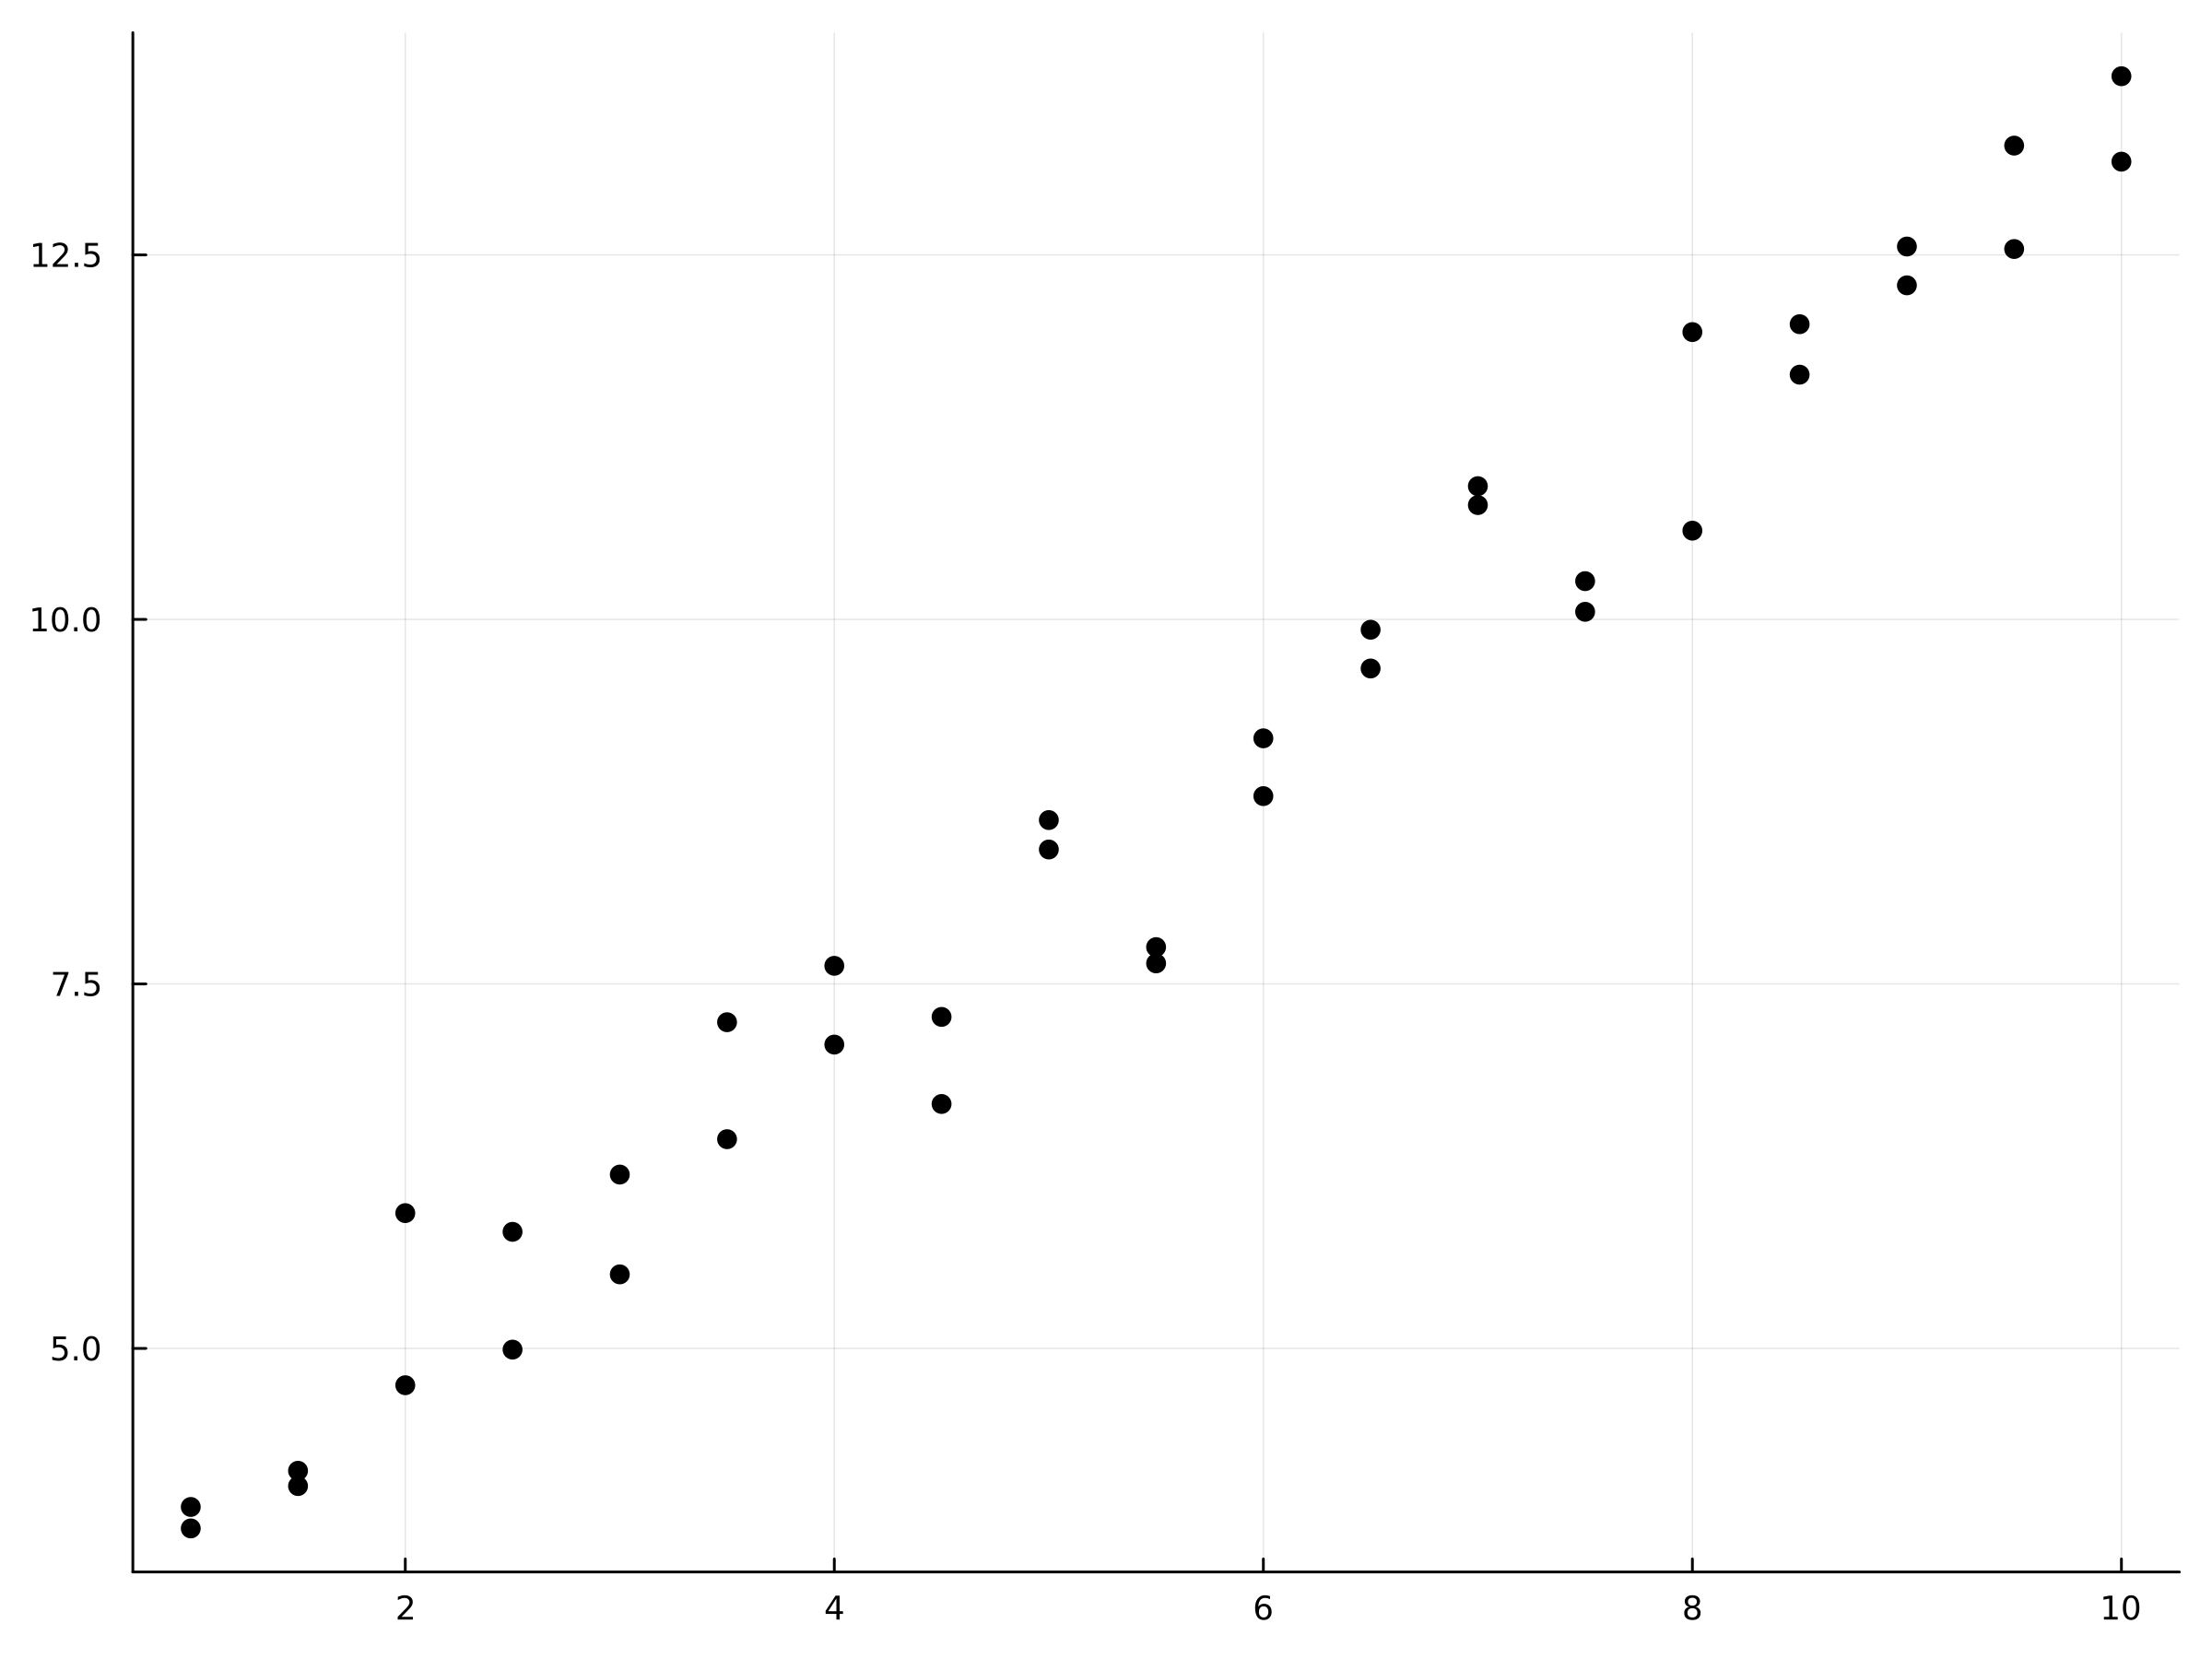

In [3]:
xvals = repeat(1:0.5:10, inner=2)
yvals = 3 .+ xvals .+ 2 .* rand(length(xvals)) .-1
scatter(xvals, yvals, color=:black, leg=false)

In [4]:
function find_best_fit(xvals,yvals)
    meanx = mean(xvals)
    meany = mean(yvals)
    stdx = std(xvals)
    stdy = std(yvals)
    r = cor(xvals,yvals)
    a = r*stdy/stdx
    b = meany - a*meanx
    return a,b
end

find_best_fit (generic function with 1 method)

In [5]:
a,b = find_best_fit(xvals,yvals)
ynew = a .* xvals .+ b;

In [6]:
np = pyimport("numpy");

  0.143435 seconds (130.49 k allocations: 6.702 MiB, 97.65% compilation time)


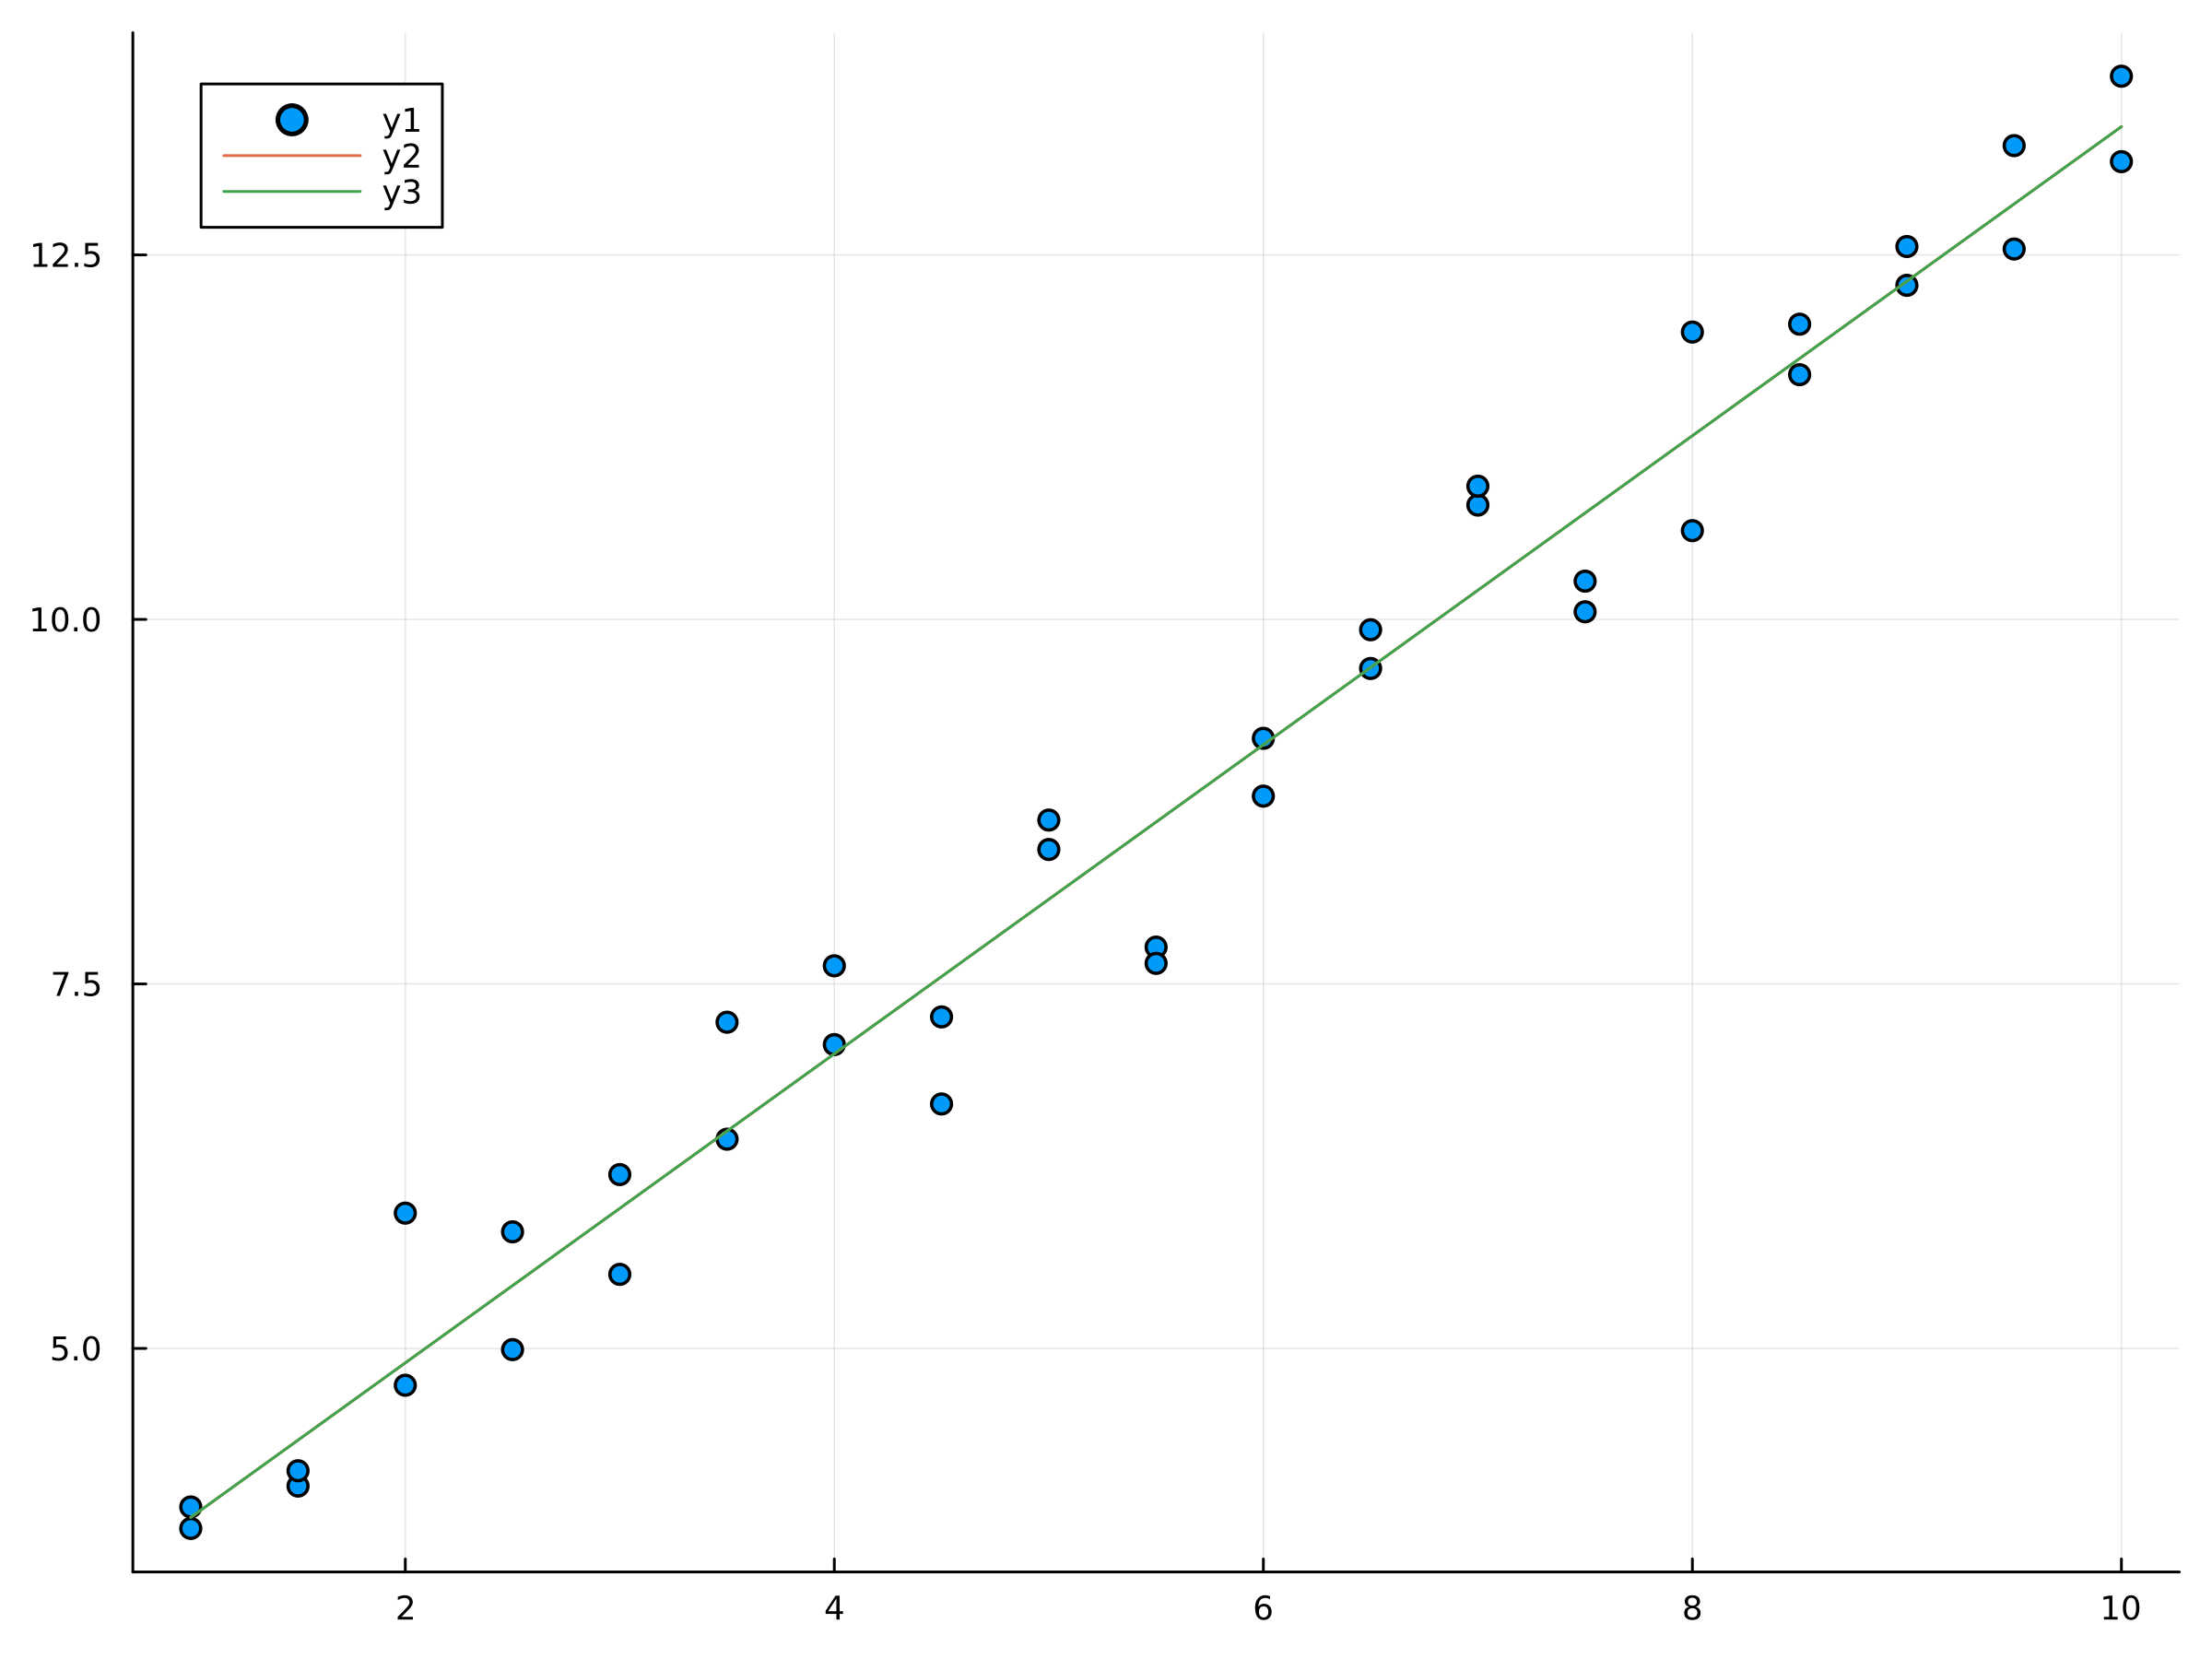

In [7]:
xdata = xvals
ydata = yvals
@time myfit = np.polyfit(xdata, ydata, 1);
ynew2 = collect(xdata) .* myfit[1] .+ myfit[2];
scatter(xvals,yvals)
plot!(xvals,ynew)
plot!(xvals,ynew2)

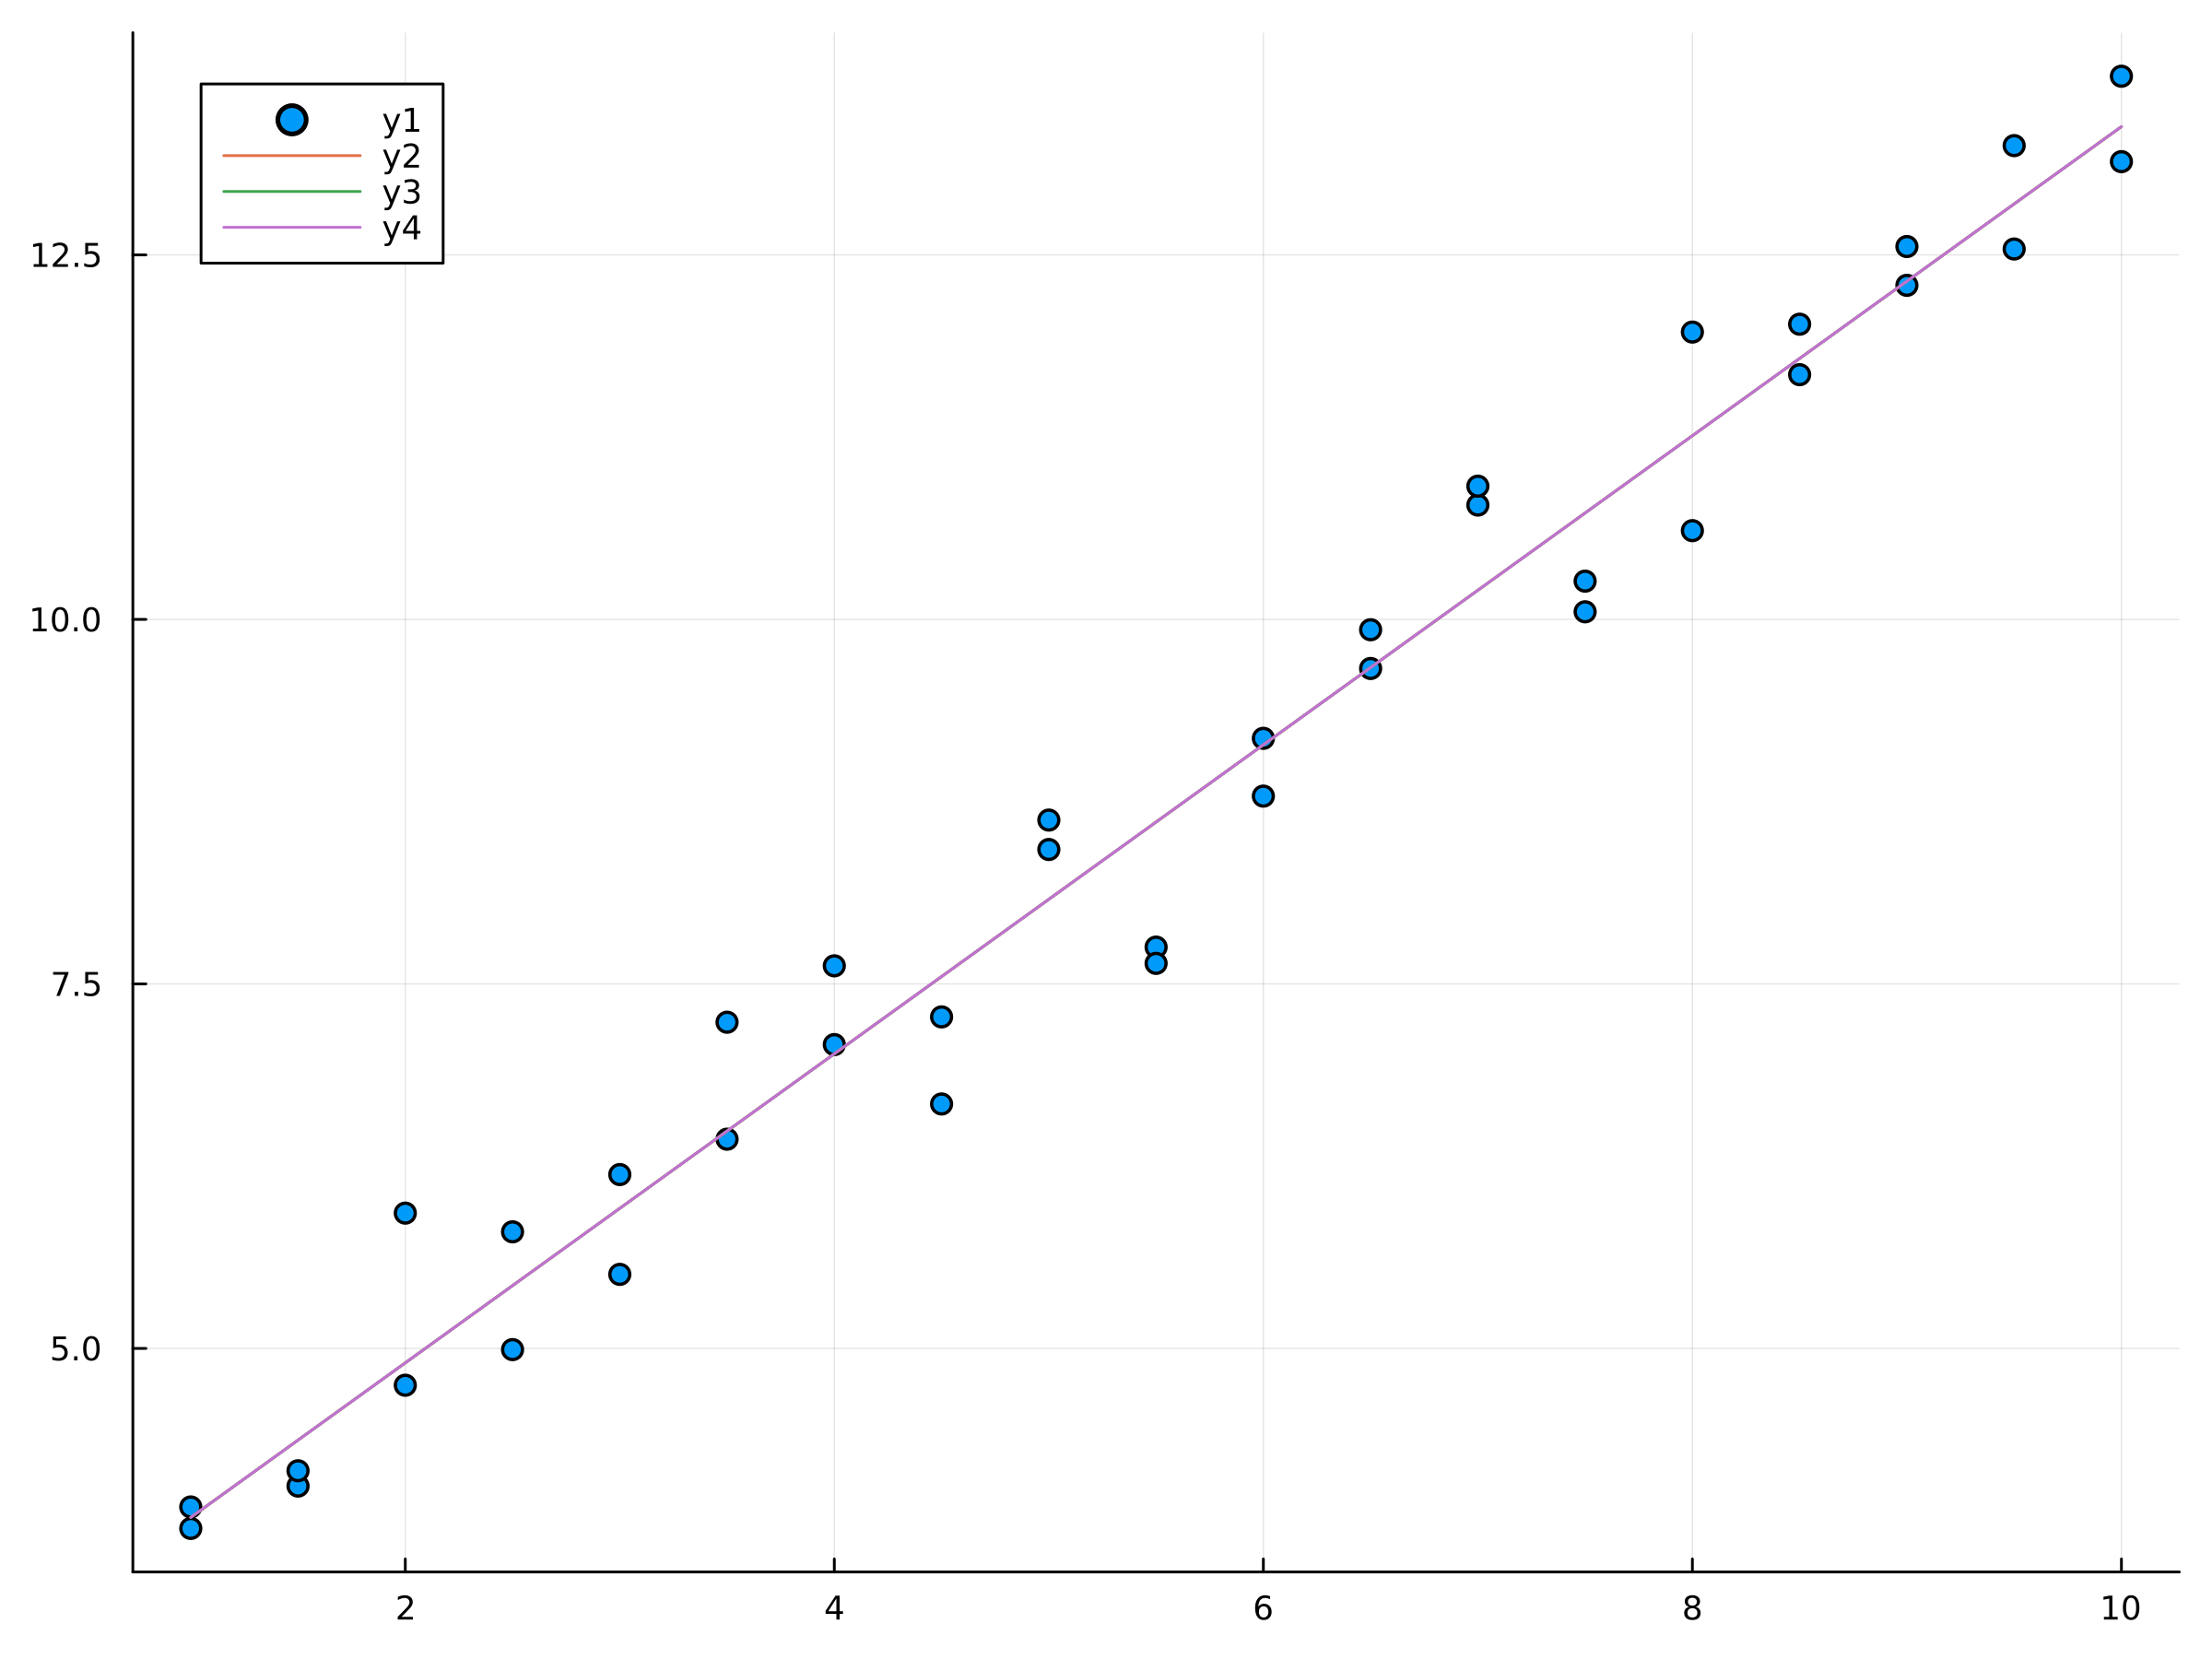

In [8]:
data = DataFrame(X=xdata, Y=ydata)
ols = lm(@formula(Y ~ X), data)
plot!(xdata,predict(ols))

Now let's get some real data. We will use housing information from zillow, check out the file `zillow_data_download_april2020.xlsx` for a quick look of what the data looks like. Our goal will be to build a linear regression model between the number of houses listed vs the number of houses sold in a few states. Fitting these models can serve as a key real estate indicator.

In [9]:
# play around with data for a bit
R = XLSX.readxlsx("data/zillow_data_download_april2020.xlsx")

XLSXFile("data/zillow_data_download_april2020.xlsx") containing 4 Worksheets
            sheetname size          range        
-------------------------------------------------
 MonthlyListings_City 8348x91       A1:CM8348    
     Sale_counts_city 28760x148     A1:ER28760   
Sales_median_price_c… 3767x148      A1:ER3767    
                 meta 1x1           A1:A1        


In [10]:
sale_counts = R["Sale_counts_city"][:]
df_sale_counts = DataFrame(sale_counts[2:end,:],Symbol.(sale_counts[1,:]))

monthly_listings = R["MonthlyListings_City"][:]
df_monthly_listings = DataFrame(monthly_listings[2:end,:],Symbol.(monthly_listings[1,:]));

In [11]:
monthly_listings_2020_02 = df_monthly_listings[!,[1,2,3,4,5,end]]
rename!(monthly_listings_2020_02, Symbol("2020-02") .=> Symbol("listings"))

sale_counts_2020_02 = df_sale_counts[!,[1,end]]
rename!(sale_counts_2020_02, Symbol("2020-02") .=> Symbol("sales"));

In [12]:
Feb2020data = innerjoin(monthly_listings_2020_02,sale_counts_2020_02,on=:RegionID) #, type="outer")
dropmissing!(Feb2020data)
sales = Feb2020data[!,:sales]
# prices = Feb2020data[!,:price]
counts = Feb2020data[!,:listings]
using DataStructures
states = Feb2020data[!,:StateName]
C = counter(states)
C.map
countvals = values(C.map)
topstates = sortperm(collect(countvals),rev=true)[1:10]
states_of_interest = collect(keys(C.map))[topstates]
all_plots = Array{Plots.Plot}(undef,10);

(si, coef(ols)) = ("CA", [0.29595375979515304])
(si, coef(ols)) = ("FL", [0.16693529057344902])
(si, coef(ols)) = ("IL", [0.22291703276169347])
(si, coef(ols)) = ("NJ", [0.25556391864492345])
(si, coef(ols)) = ("MI", [0.2925436820147375])
(si, coef(ols)) = ("TX", [0.24732835944836878])
(si, coef(ols)) = ("PA", [0.310066636803275])
(si, coef(ols)) = ("OH", [0.4569949754409864])
(si, coef(ols)) = ("NC", [0.4800747758857476])
(si, coef(ols)) = ("NY", [0.19151984869233082])


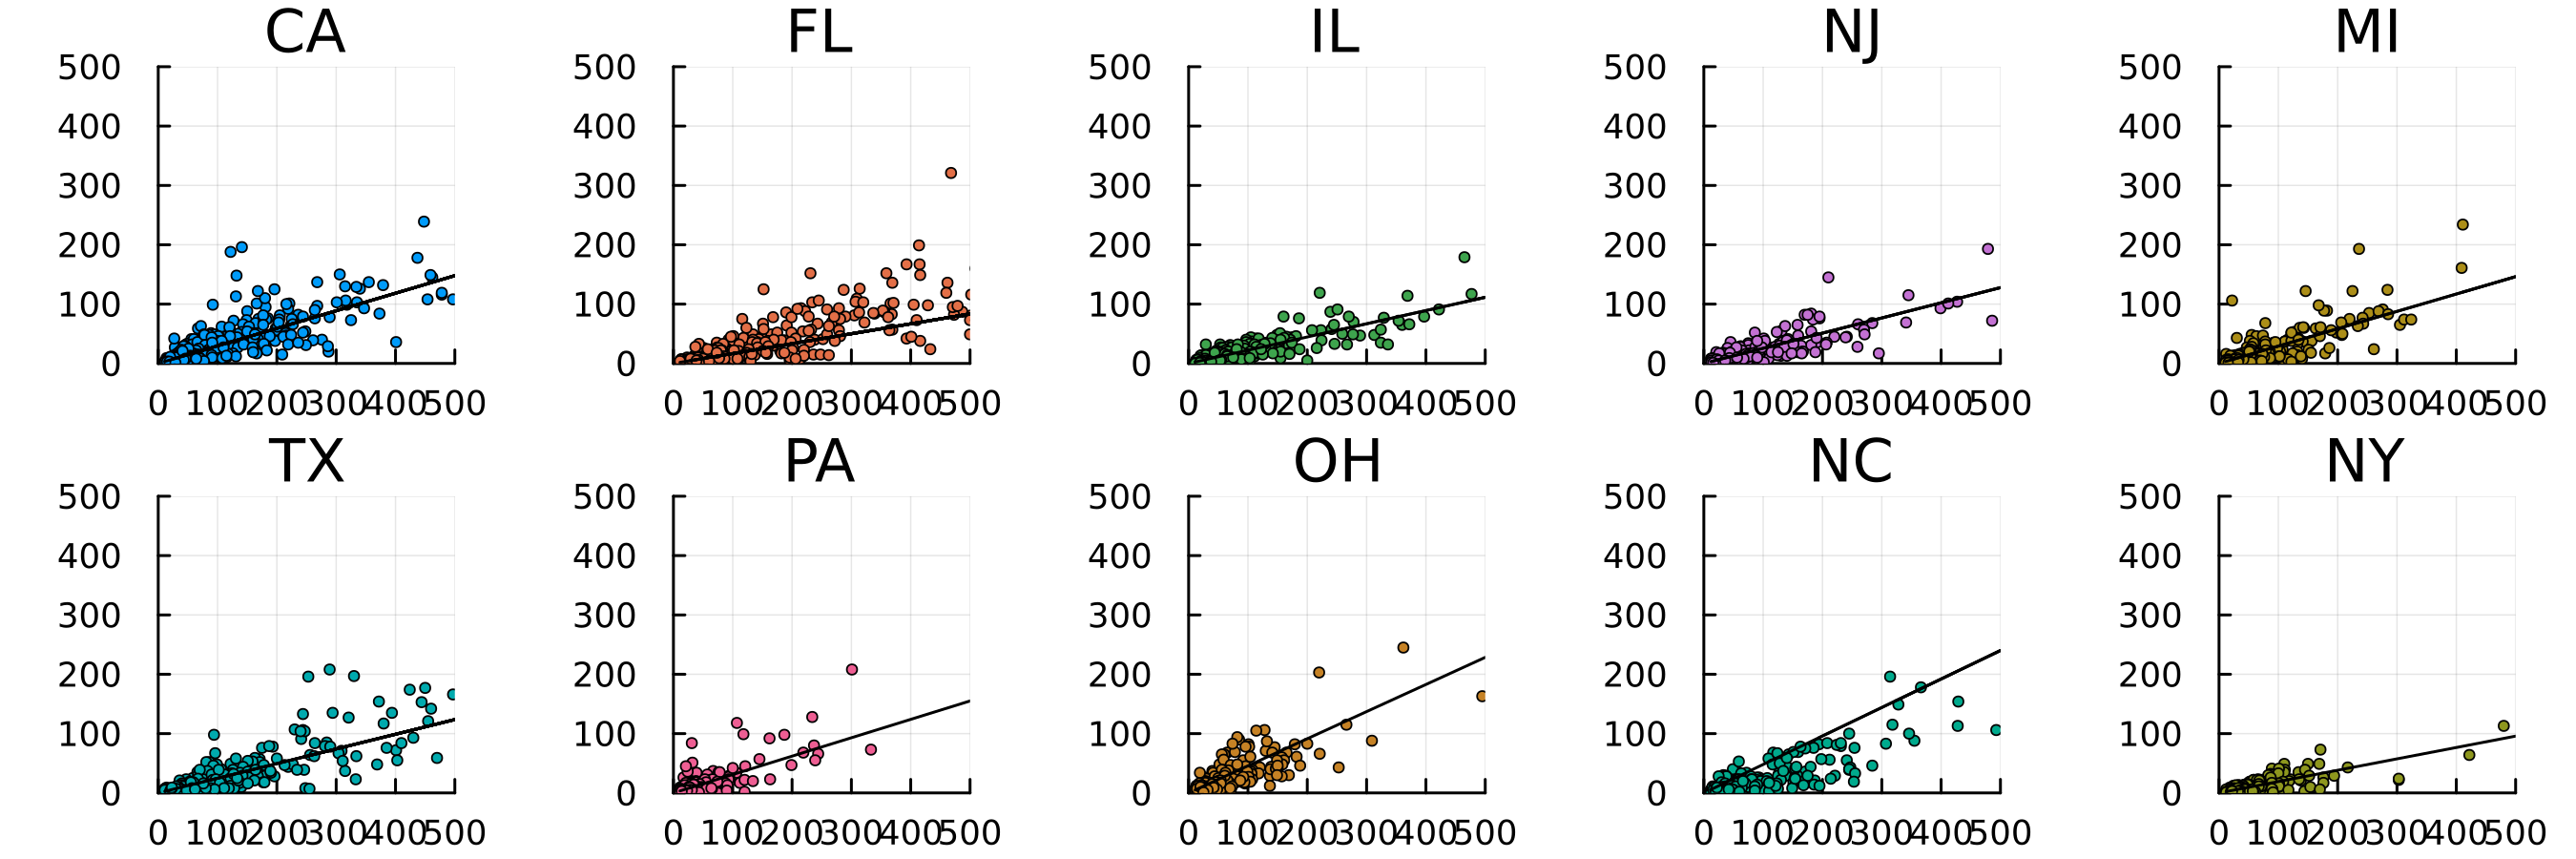

In [13]:
all_plots = Array{Plots.Plot}(undef,10)
for (i,si) in enumerate(states_of_interest)
    curids = findall(Feb2020data[!,:StateName].==si)
    data = DataFrame(X=float.(counts[curids]), Y=float.(sales[curids]))
    ols = GLM.lm(@formula(Y ~ 0 + X), data)    
    all_plots[i] = scatter(counts[curids],sales[curids],markersize=2,
        xlim=(0,500),ylim=(0,500),color=i,aspect_ratio=:equal,
        legend=false,title=si)
    @show si,coef(ols)
    plot!(counts[curids],predict(ols),color=:black)
end
plot(all_plots...,layout=(2,5),size=(900,300))

(si, coef(ols)) = ("CA", [6.803086464628309, 0.28798374289950357])
(si, coef(ols)) = ("FL", [19.126255819233386, 0.15510798334559428])
(si, coef(ols)) = ("IL", [0.6626439876883514, 0.2226325765807212])
(si, coef(ols)) = ("NJ", [-1.9635911642225732, 0.2650303535602978])
(si, coef(ols)) = ("MI", [-0.9181942041703473, 0.29768705032459525])
(si, coef(ols)) = ("TX", [5.241220767319292, 0.24566620049636262])
(si, coef(ols)) = ("PA", [-0.21362448579952723, 0.3101955410309725])
(si, coef(ols)) = ("OH", [-6.026958739166818, 0.47909280478486926])
(si, coef(ols)) = ("NC", [-24.60003985327959, 0.5302793903364814])
(si, coef(ols)) = ("NY", [-0.20048638474403055, 0.191535092167981])


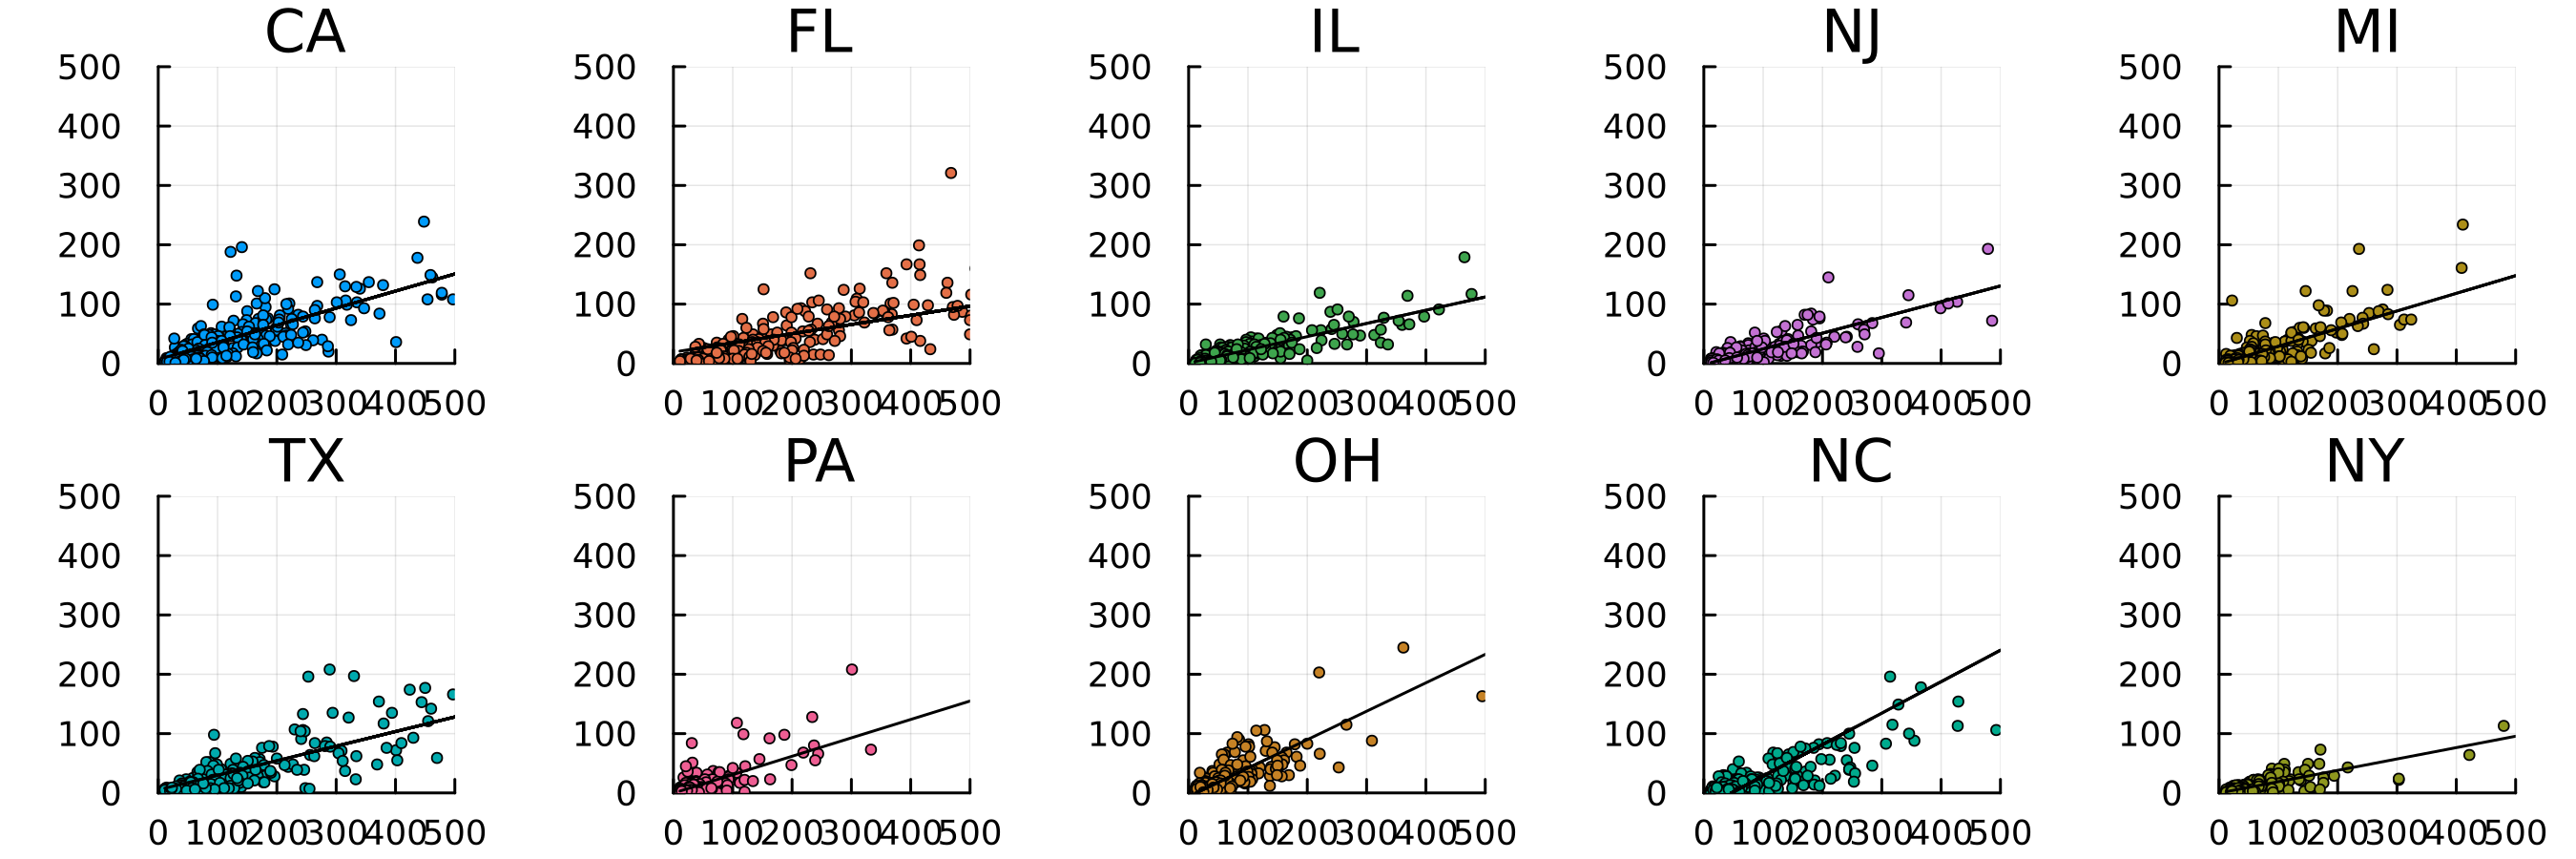

In [14]:
all_plots = Array{Plots.Plot}(undef,10)
for (i,si) in enumerate(states_of_interest)
    curids = findall(Feb2020data[!,:StateName].==si)
    data = DataFrame(X=float.(counts[curids]), Y=float.(sales[curids]))
    ols = GLM.lm(@formula(Y ~ X), data)    
    all_plots[i] = scatter(counts[curids],sales[curids],markersize=2,
        xlim=(0,500),ylim=(0,500),color=i,aspect_ratio=:equal,
        legend=false,title=si)
    @show si,coef(ols)
    plot!(counts[curids],predict(ols),color=:black)
end
plot(all_plots...,layout=(2,5),size=(900,300))

(si, coef(ols)) = ("CA", [0.29595375979515304])
(si, coef(ols)) = ("FL", [0.16693529057344902])
(si, coef(ols)) = ("IL", [0.22291703276169347])
(si, coef(ols)) = ("NJ", [0.25556391864492345])
(si, coef(ols)) = ("MI", [0.2925436820147375])
(si, coef(ols)) = ("TX", [0.24732835944836878])
(si, coef(ols)) = ("PA", [0.310066636803275])
(si, coef(ols)) = ("OH", [0.4569949754409864])
(si, coef(ols)) = ("NC", [0.4800747758857476])
(si, coef(ols)) = ("NY", [0.19151984869233082])


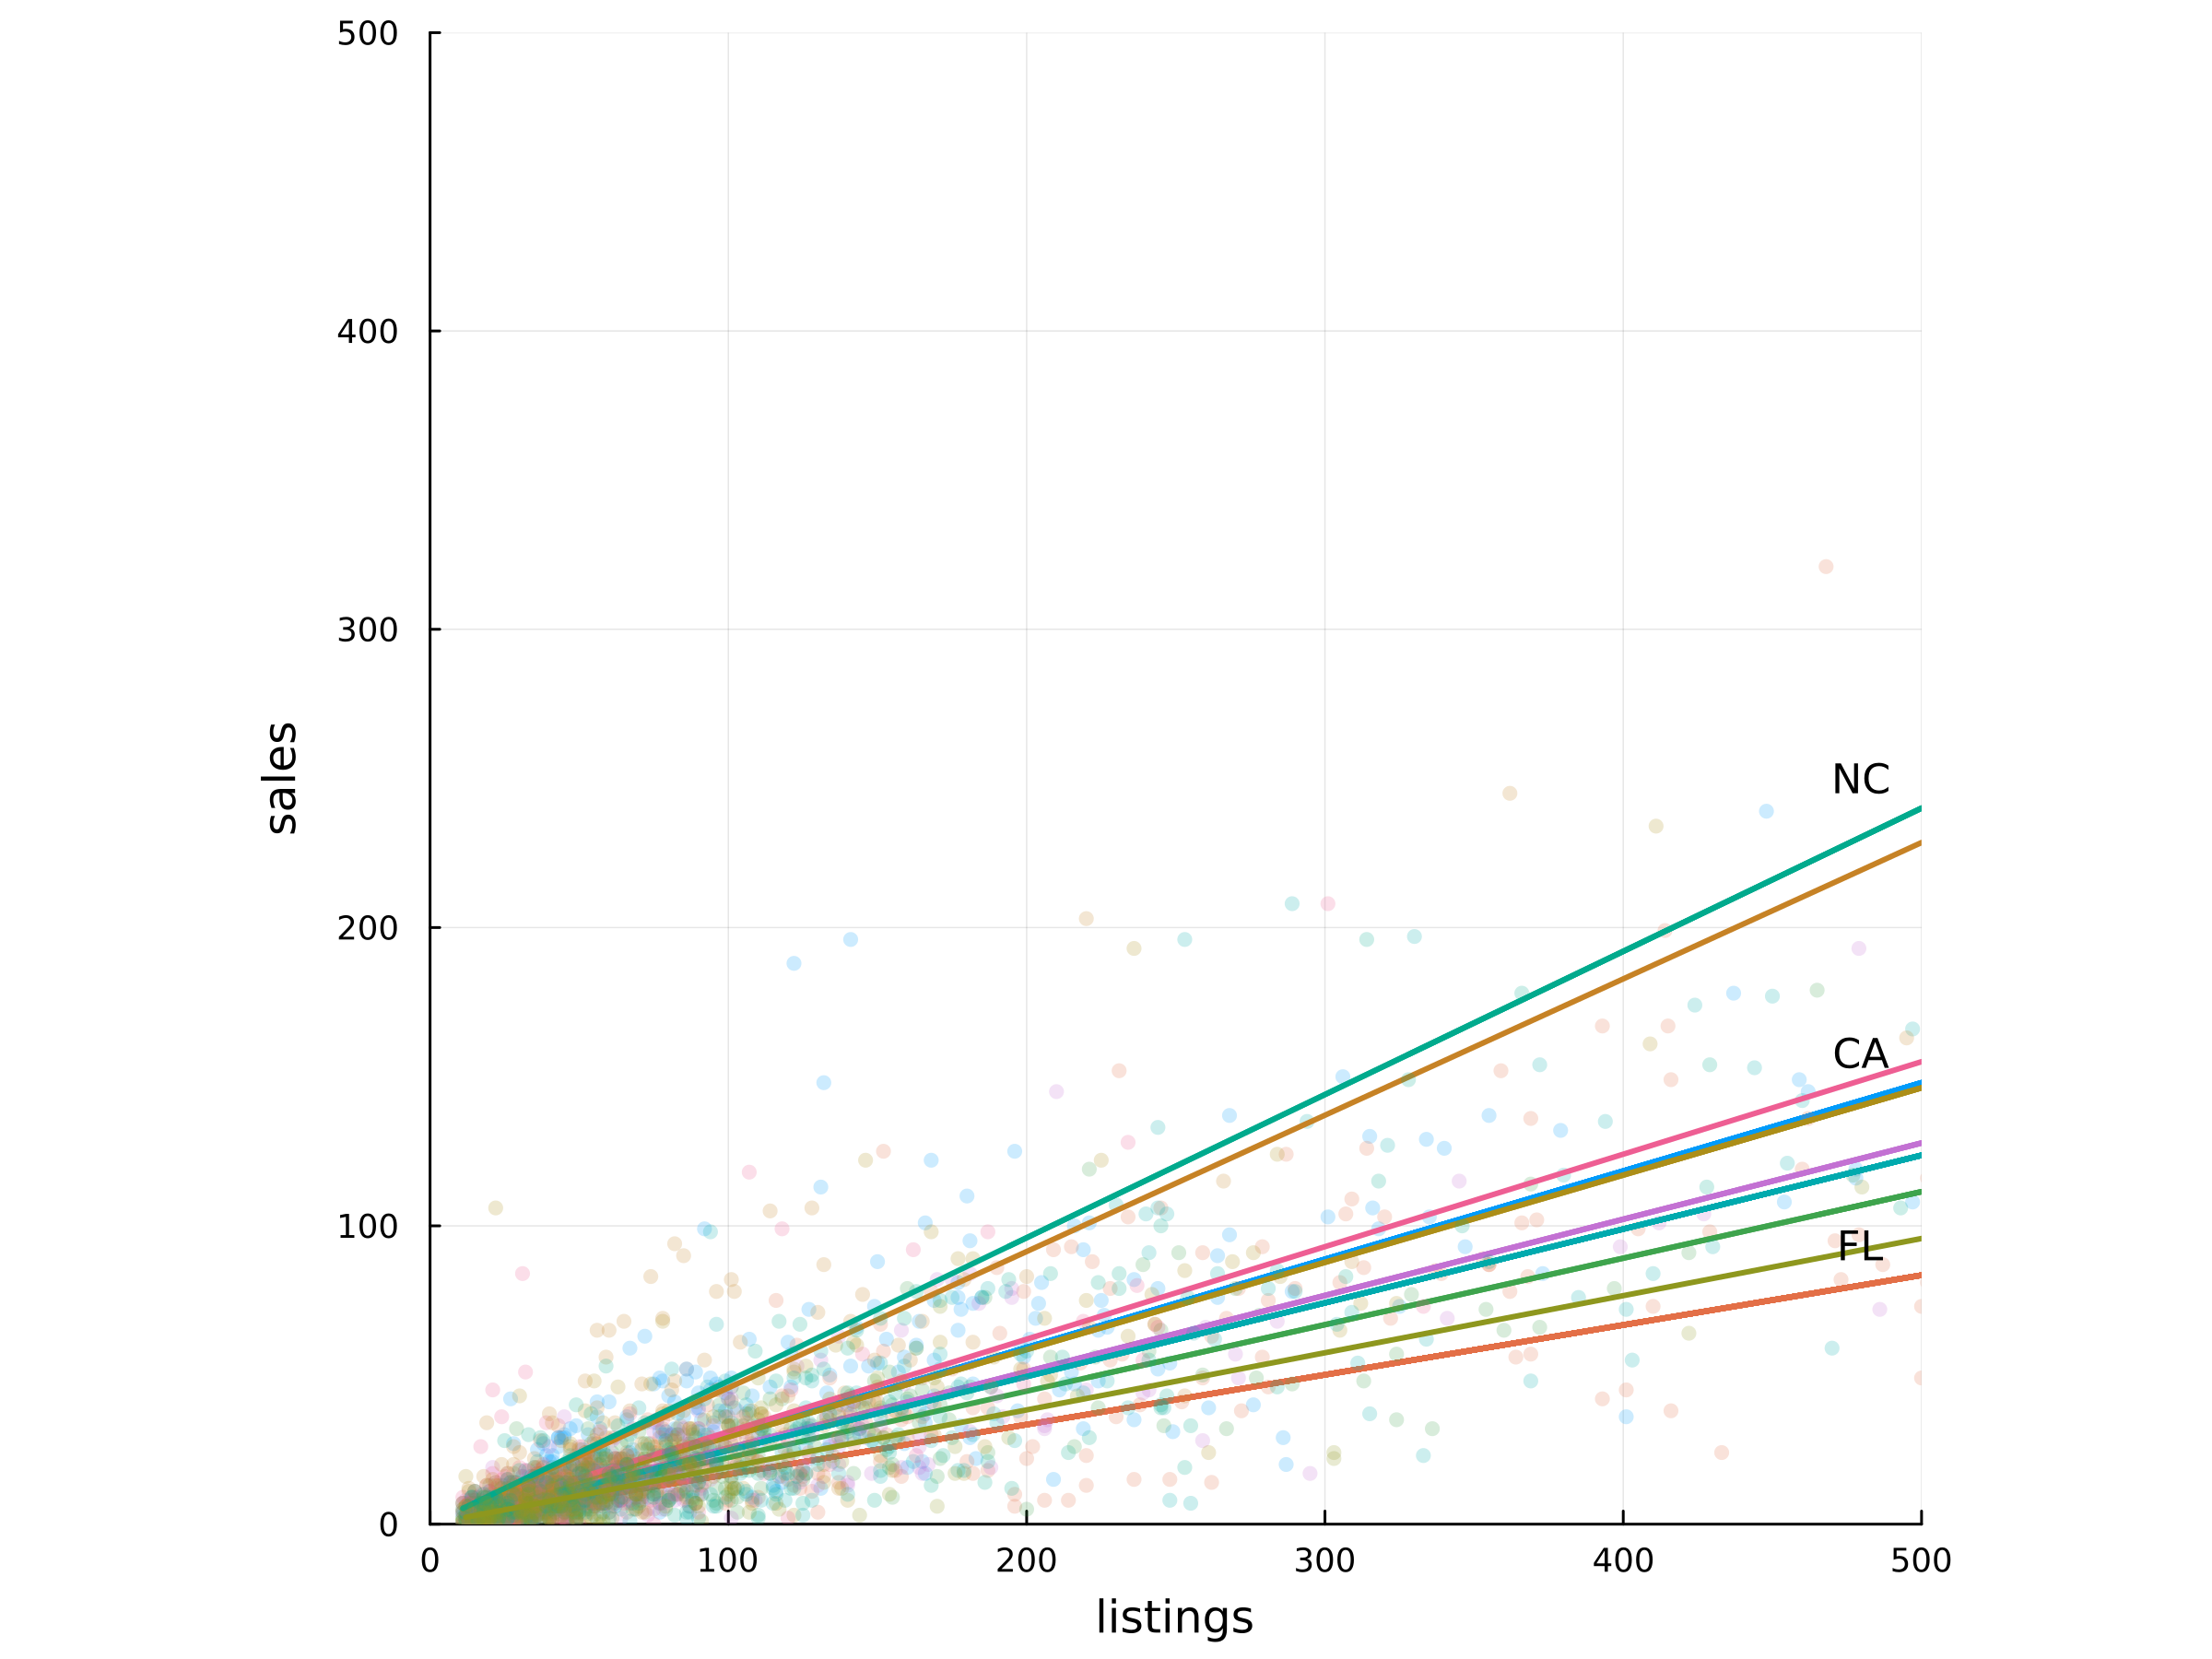

In [15]:
plot()
for (i,si) in enumerate(states_of_interest)
    curids = findall(Feb2020data[!,:StateName].==si)
    data = DataFrame(X=float.(counts[curids]), Y=float.(sales[curids]))
    ols = GLM.lm(@formula(Y ~ 0 + X), data)    
    scatter!(counts[curids],sales[curids],markersize=2,
        xlim=(0,500),ylim=(0,500),color=i,aspect_ratio=:equal,
        legend=false,marker=(3,3,stroke(0)),alpha=0.2)
        if si == "NC" || si == "CA" || si == "FL"
            annotate!([(500-20,10+coef(ols)[1]*500,text(si,10))])
        end
    @show si,coef(ols)
    plot!(counts[curids],predict(ols),color=i,linewidth=2)
end
# plot(all_plots...,layout=(2,5),size=(900,300))
xlabel!("listings")
ylabel!("sales")

---- 
### 🟠 Logistic regression
So far, we have shown several ways to solve the linear regression problem in Julia. Here, we will first start with a motivating example of when you would want to use logistic regression. Let's assume that our predictor vector is binary (`0` or `1`), let's fit a linear regression model.

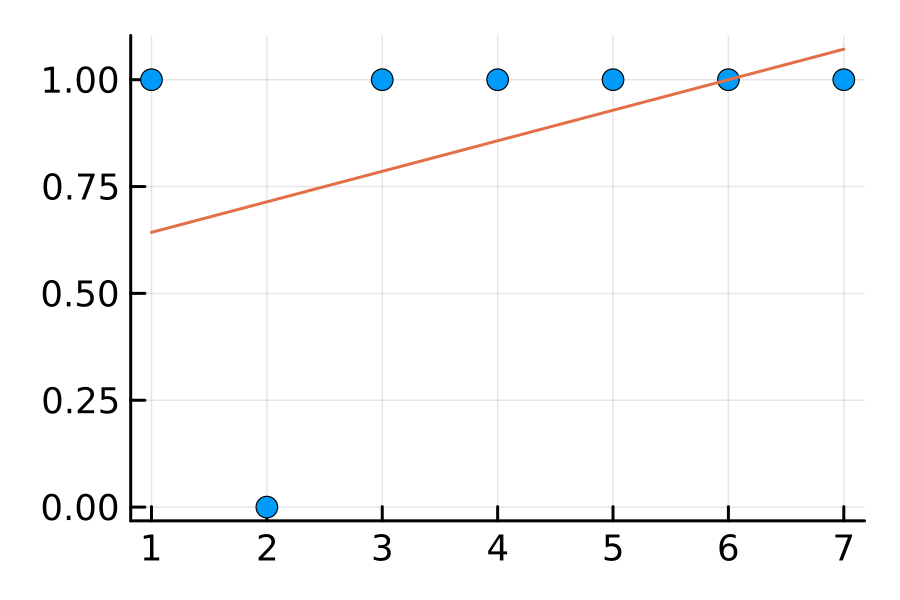

In [16]:
data = DataFrame(X=[1,2,3,4,5,6,7], Y=[1,0,1,1,1,1,1])
linear_reg = lm(@formula(Y ~ X), data)
scatter(data[!,:X],data[!,:Y],legend=false,size=(300,200))
plot!(1:7,predict(linear_reg))

What this plot quickly shows is that linear regression may end up predicting values outside the `[0,1]` interval. For an example like this, we will use logistic regression. Interestingly, a generalized linear model (https://en.wikipedia.org/wiki/Generalized_linear_model) unifies concepts like linear regression and logistic regression, and the `GLM` package allows you to apply either of these regressions easily by specifying the `distribution family` and the `link` function. 

To apply logistic regression via the `GLM` package, you can readily use the `Binomial()` family and the `LogitLink()` link function. 

Let's load some data and take a look at one example.

In [17]:
# we will load this data from RDatasets
cats = dataset("MASS", "cats");

We will map the sex of each cat to a binary 0/1 value.

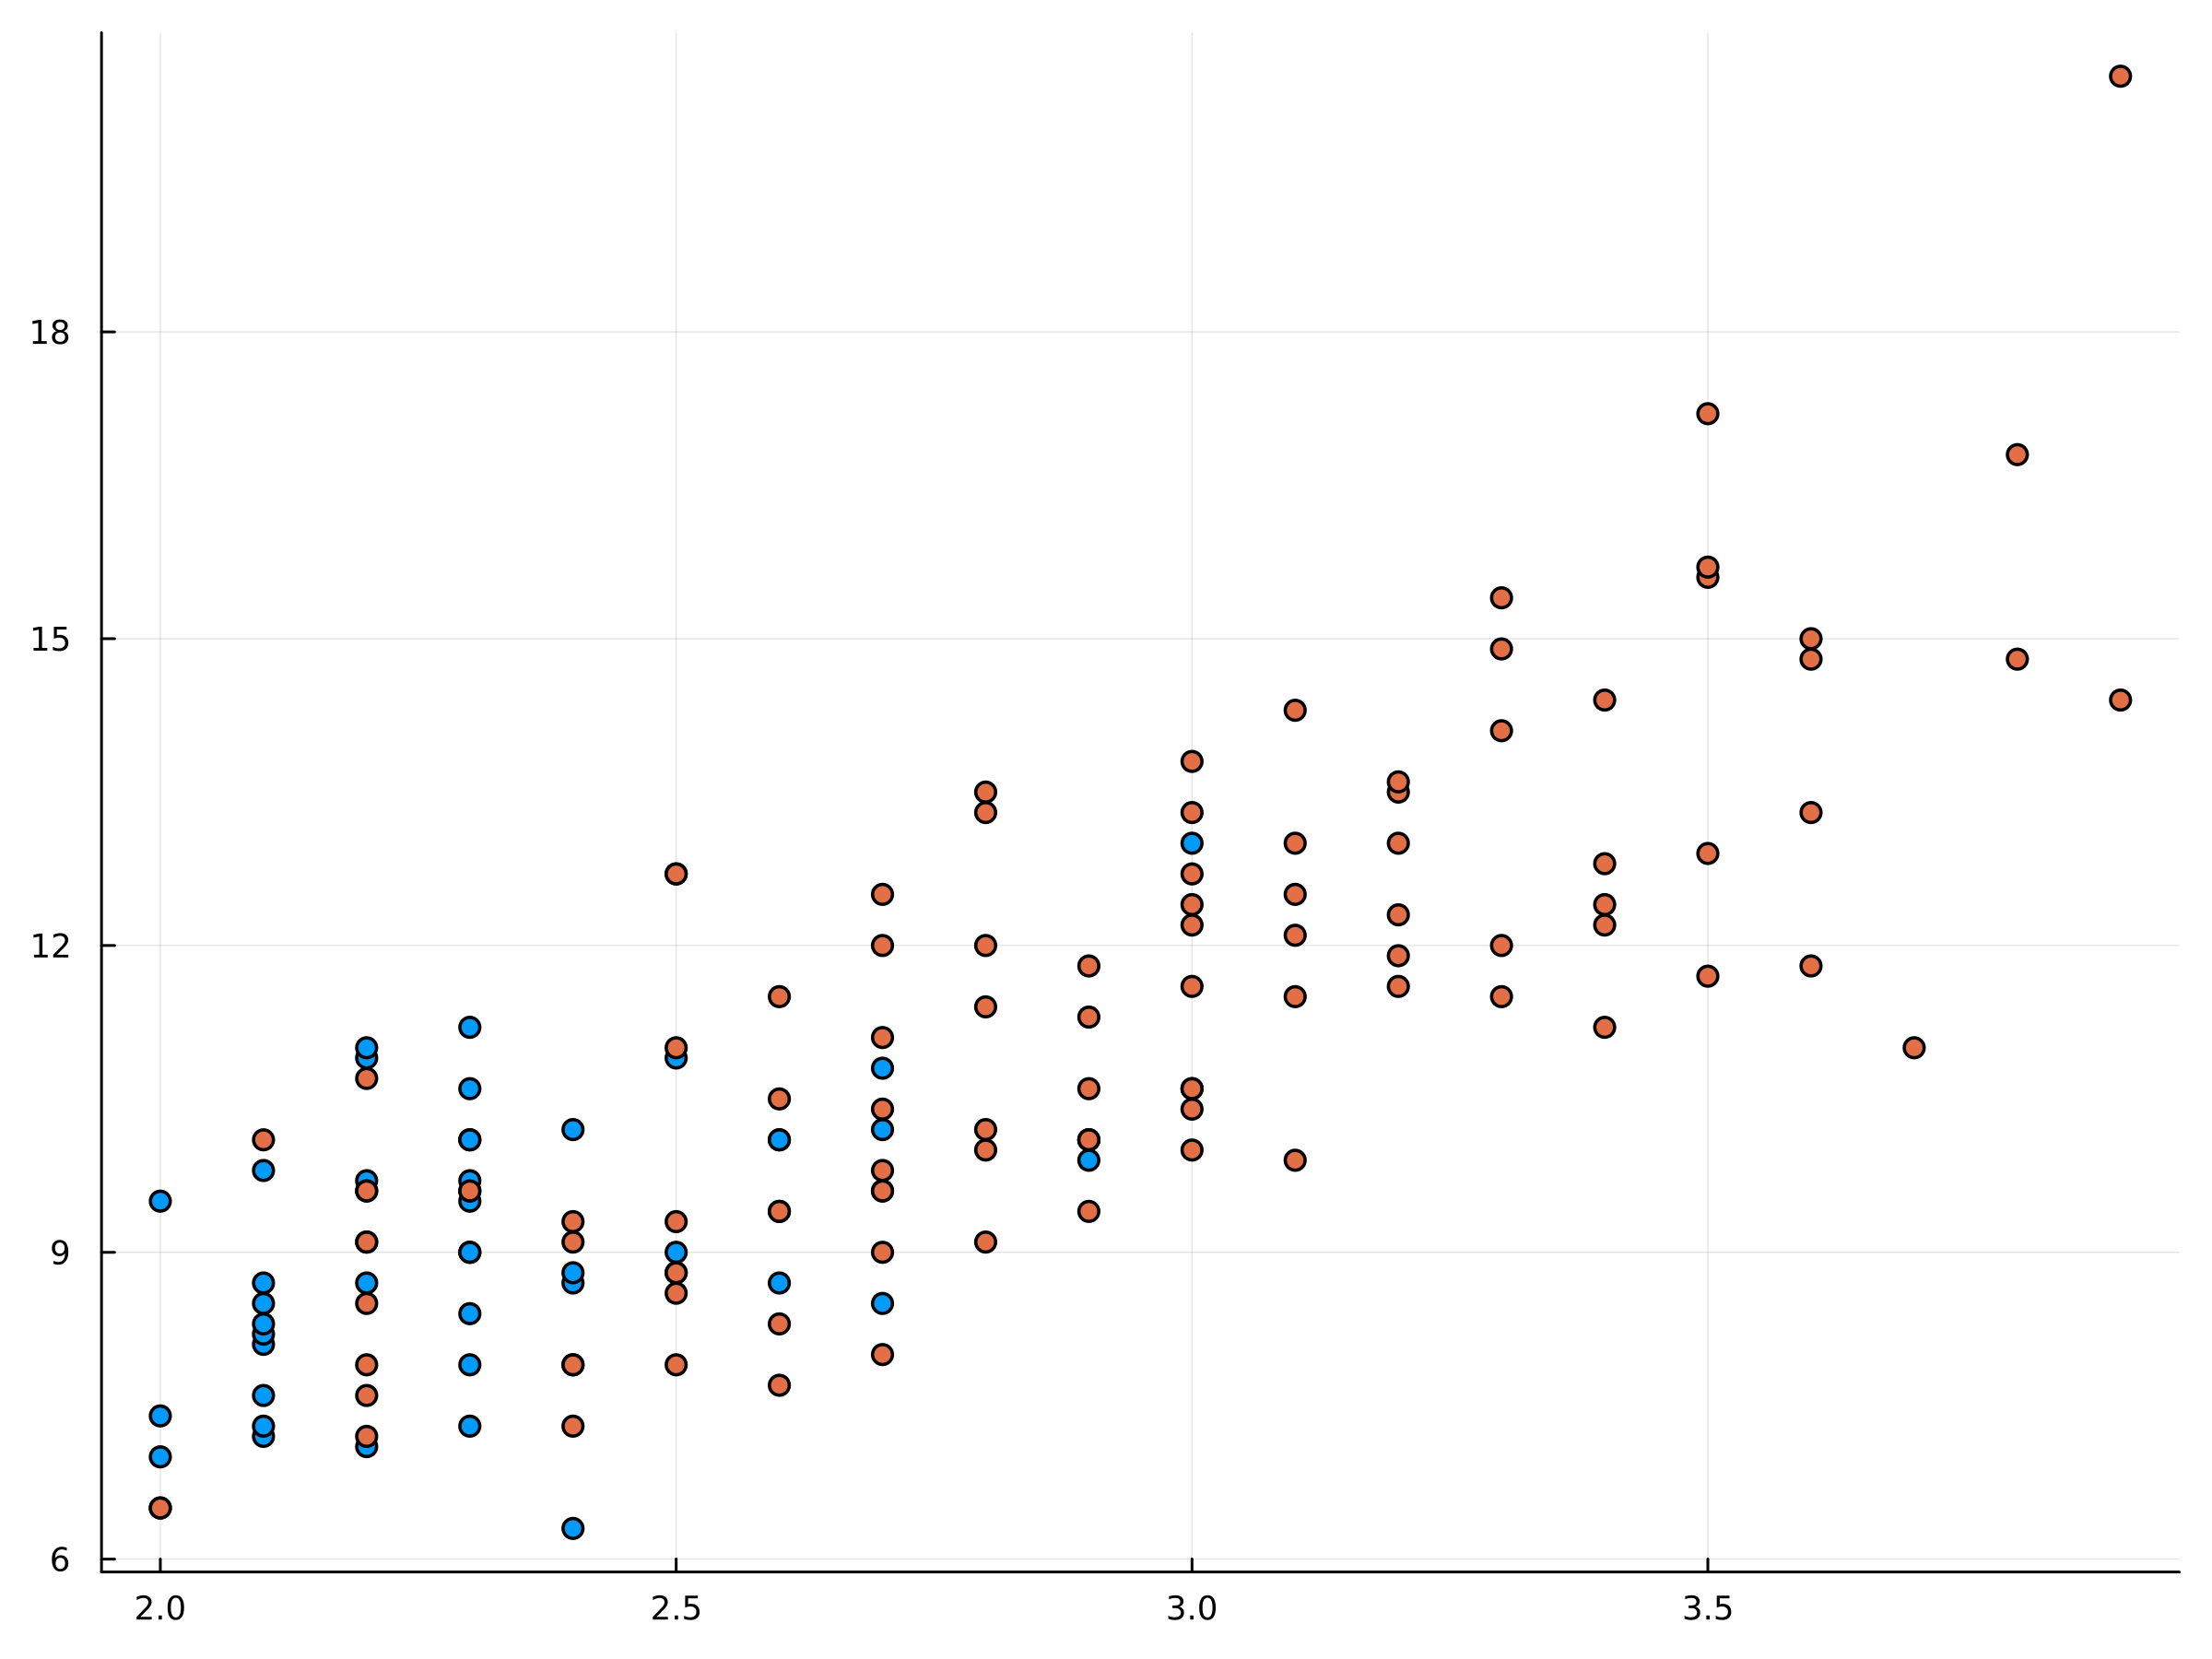

In [18]:
lmap = labelmap(cats[!,:Sex])
ci = labelencode(lmap, cats[!,:Sex])
scatter(cats[!,:BWt],cats[!,:HWt],color=ci,legend=false)

Females (color 1) seem to be more present in the lower left corner and Males (color 2) seem to be present in the top right corner. Let's run a logistic regression model on this data.

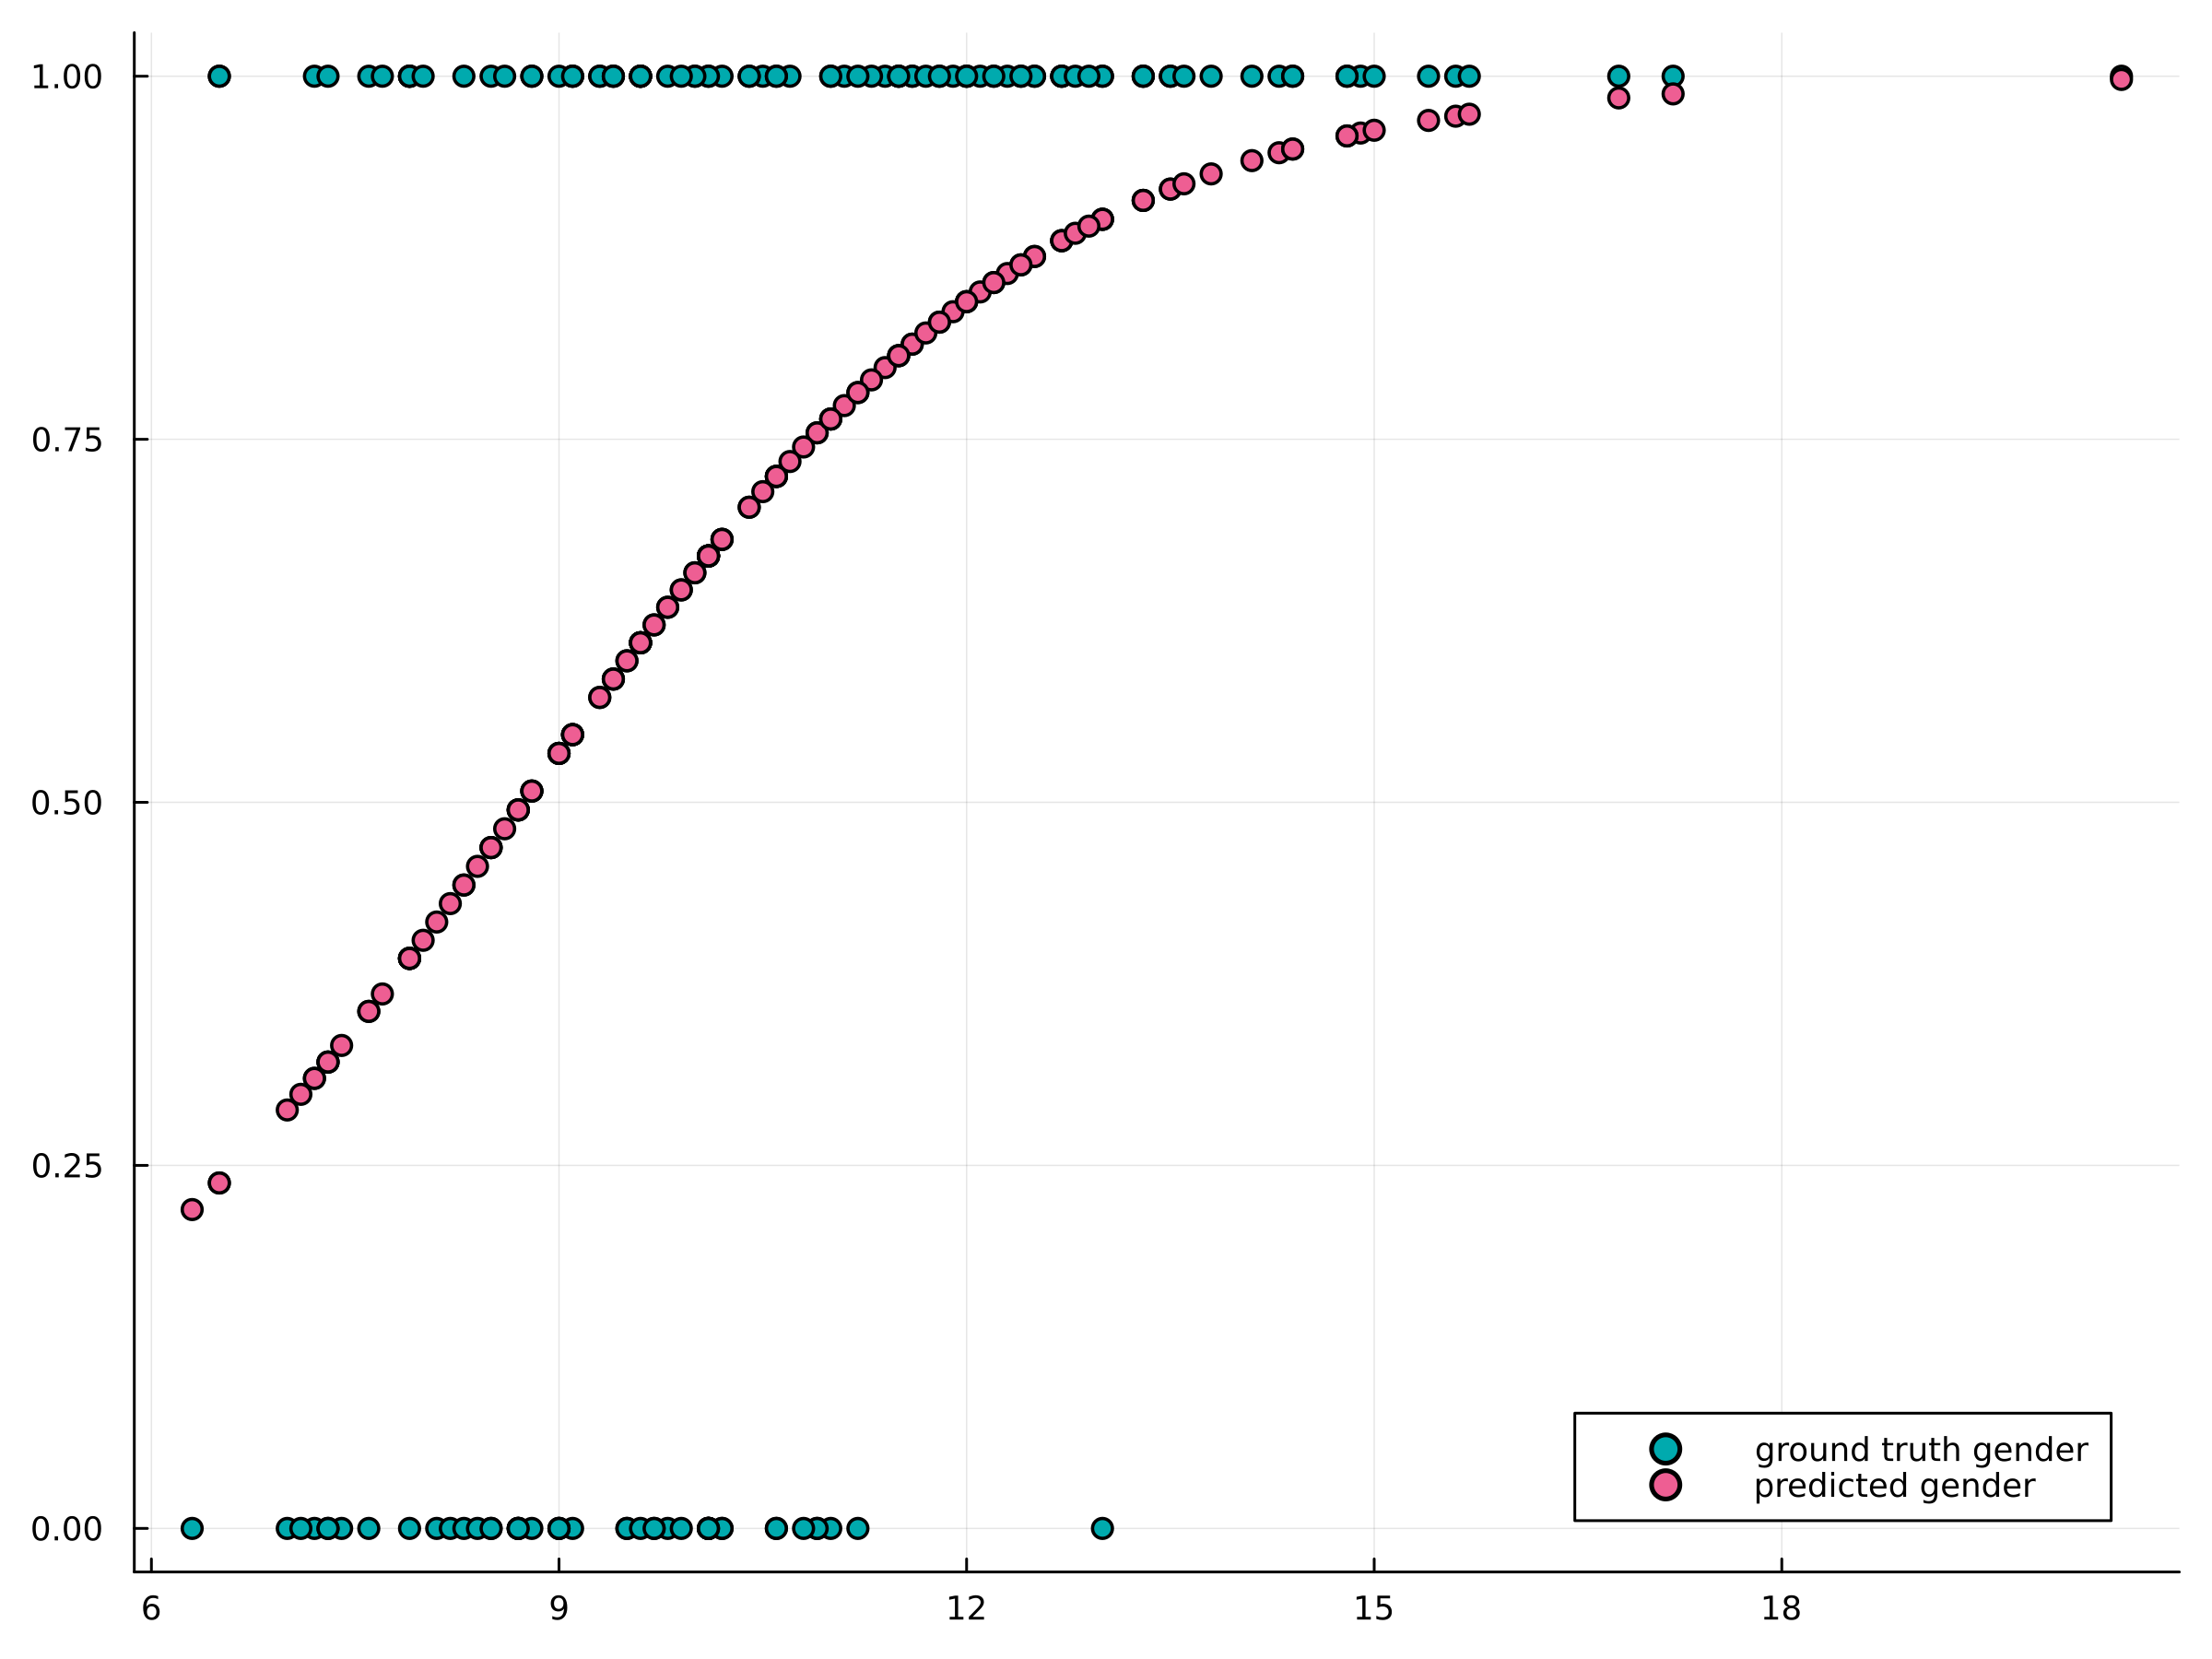

In [19]:
data = DataFrame(X=cats[!,:HWt], Y=ci.-1)
probit = glm(@formula(Y ~ X), data, Binomial(), LogitLink())
scatter(data[!,:X],data[!,:Y],label="ground truth gender",color=6)
scatter!(data[!,:X],predict(probit),label="predicted gender",color=7)

As you can see, contrary to the linear regression case, the predicted values do not go beyond 1.

-----
### 🟠 Non linear regression
Finally, sometimes you may have a set of points and the goal is to fit a non-linear function (maybe a quadratic function, a cubic function, an exponential function...). The way we would solve such a problem is by minimizing the least square error between the fitted function and the observations we have. We will use the package `LsqFit` for this task. Note that this problem is usually modeled as a numerical optimizaiton problem.

We will first set up our data.

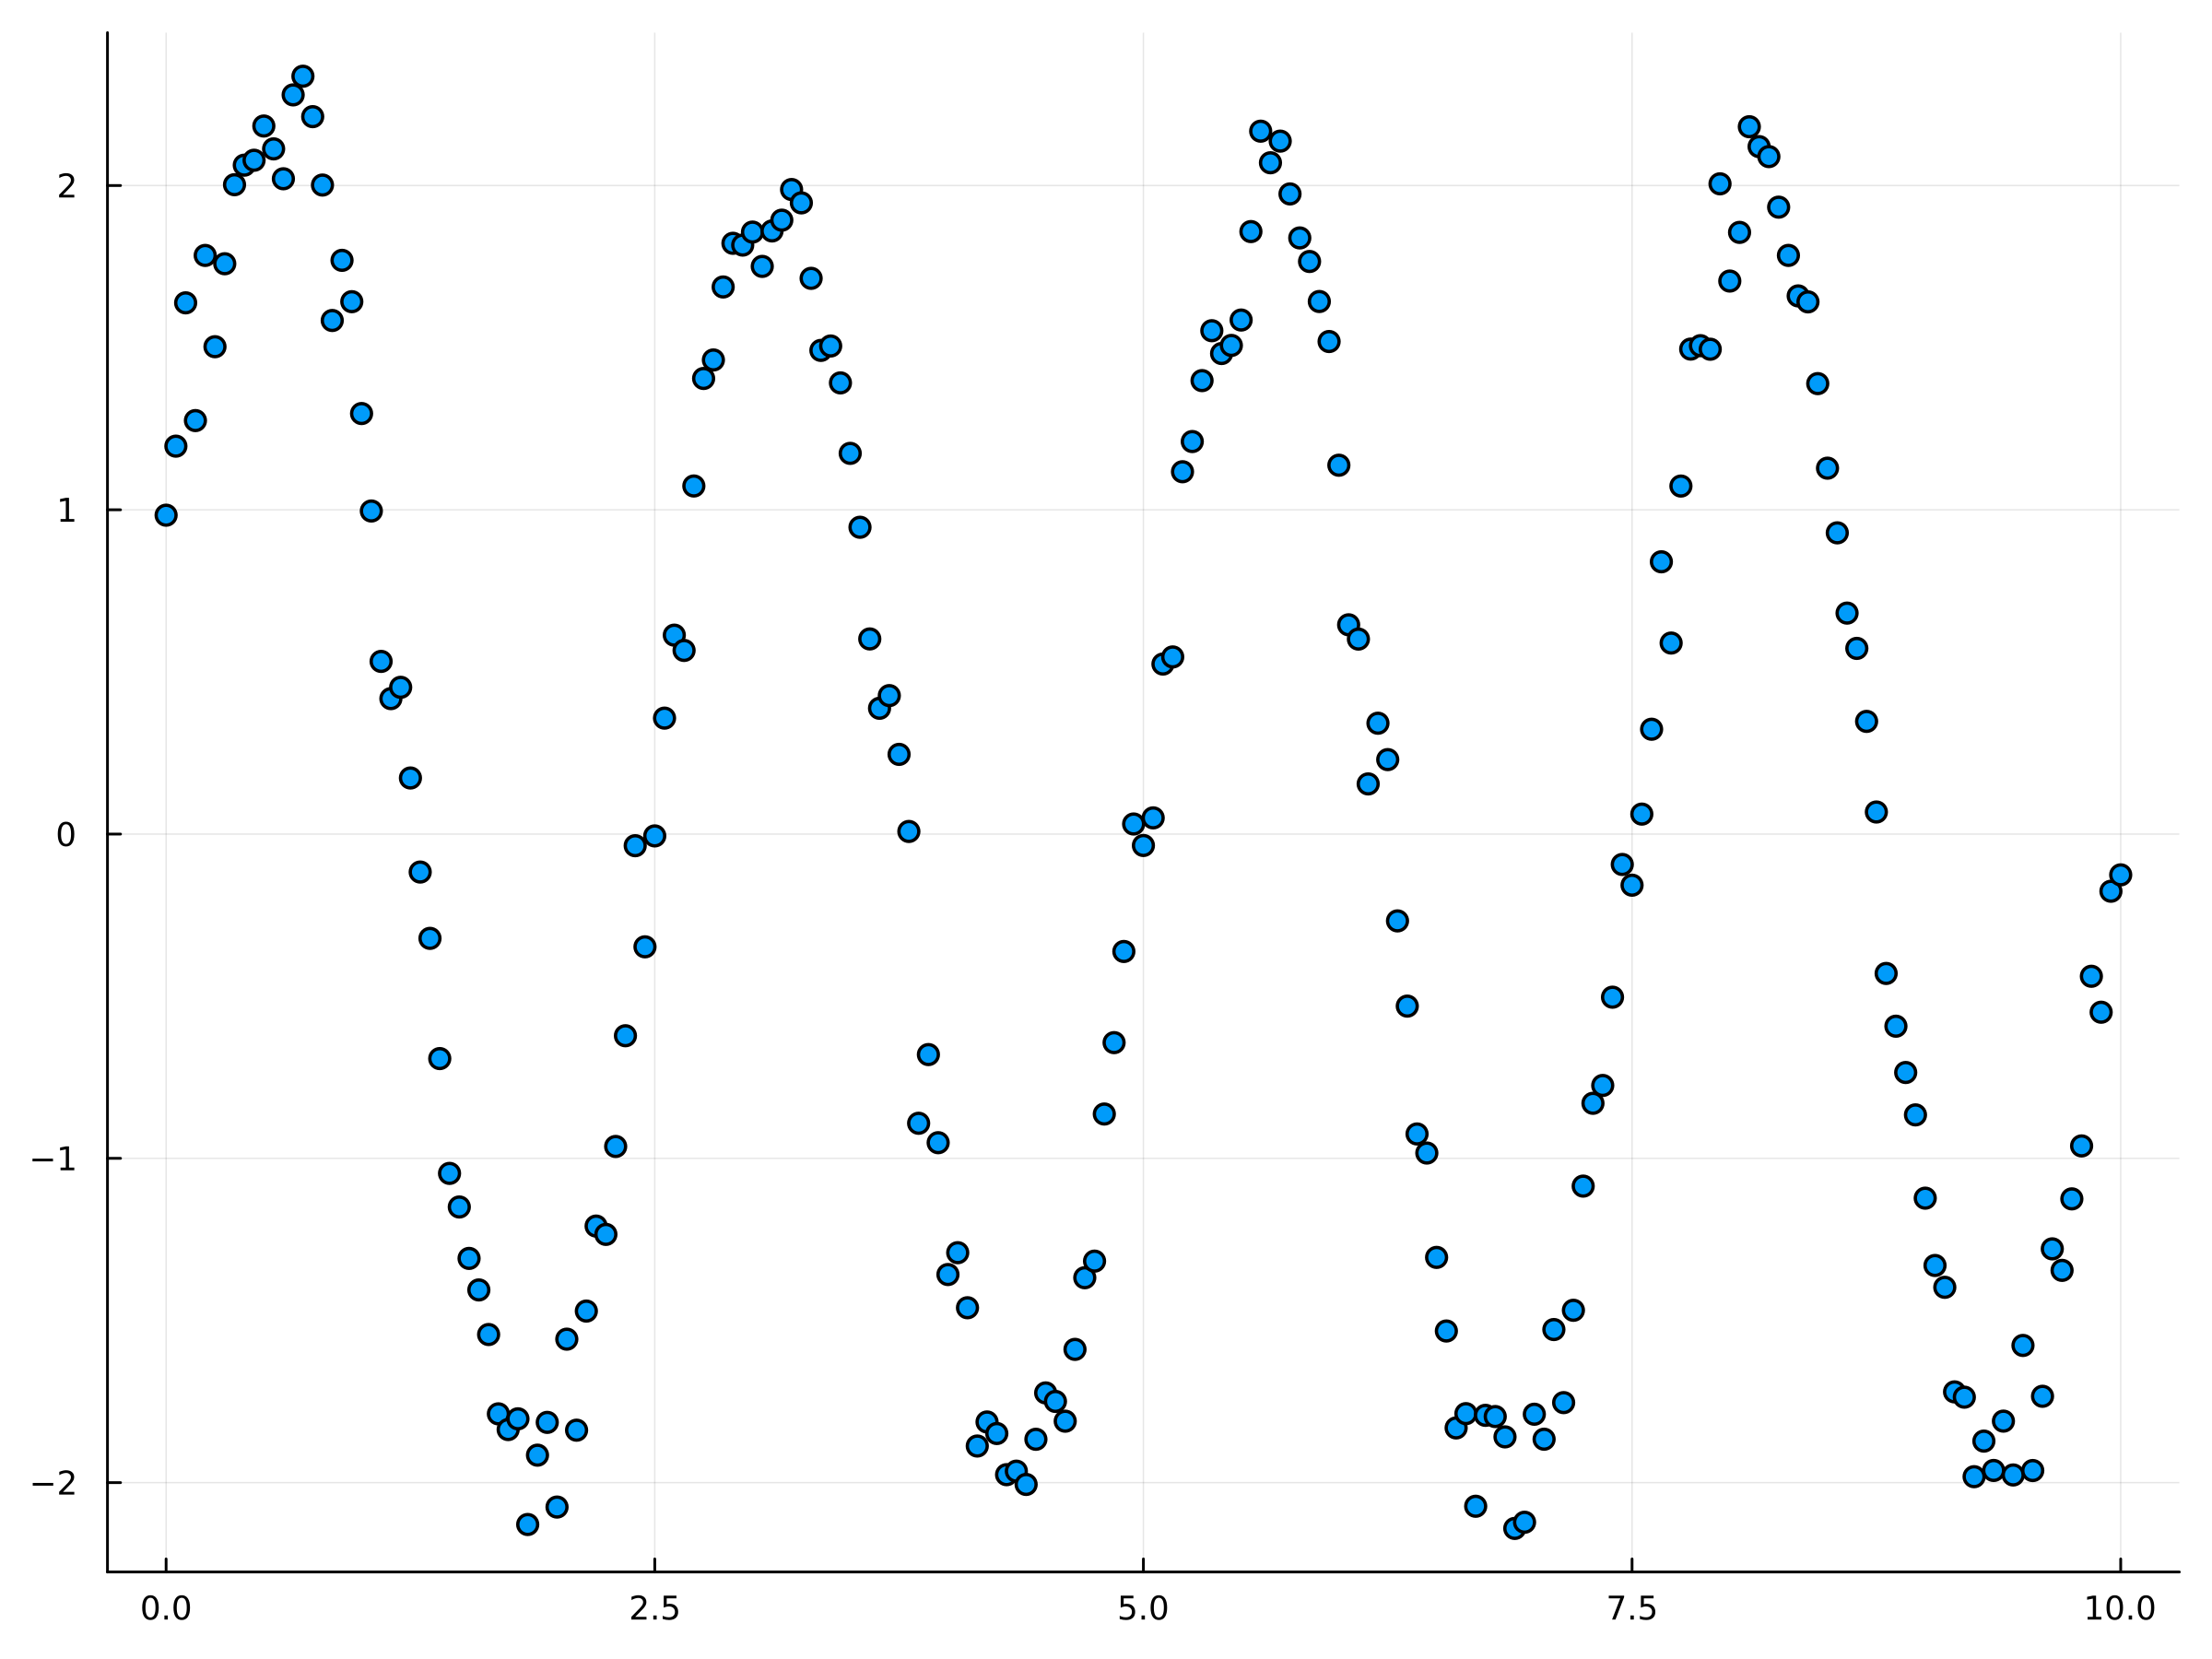

In [20]:
xvals = 0:0.05:10
yvals = 1*exp.(-xvals*2) + 2*sin.(0.8*pi*xvals) + 0.15 * randn(length(xvals));
scatter(xvals,yvals,legend=false)

Then, we set up the model with `model(x,p)`. The vector `p` is what to be estimated given a set of values `x`.

In [21]:
@. model(x, p) = p[1]*exp(-x*p[2]) + p[3]*sin(0.8*pi*x)
p0 = [0.5, 0.5, 0.5]
myfit = curve_fit(model, xvals, yvals, p0);

⚠️ A note about `curve_fit`: this function can take multiple other inputs, for instance the Jacobian of what you are trying to fit. We don't dive into these details here, but be sure to check out the `LsqFit` package to see what other things you can can pass to create a better fit.

Also note that julia has multiple packages that allow you to create Jacobians so you don't have to write them yourself. Two such packages are `FiniteDifferences` or `ForwardDiff`.

↪️ Back to our example. We are ready now to plot the curve we have generated

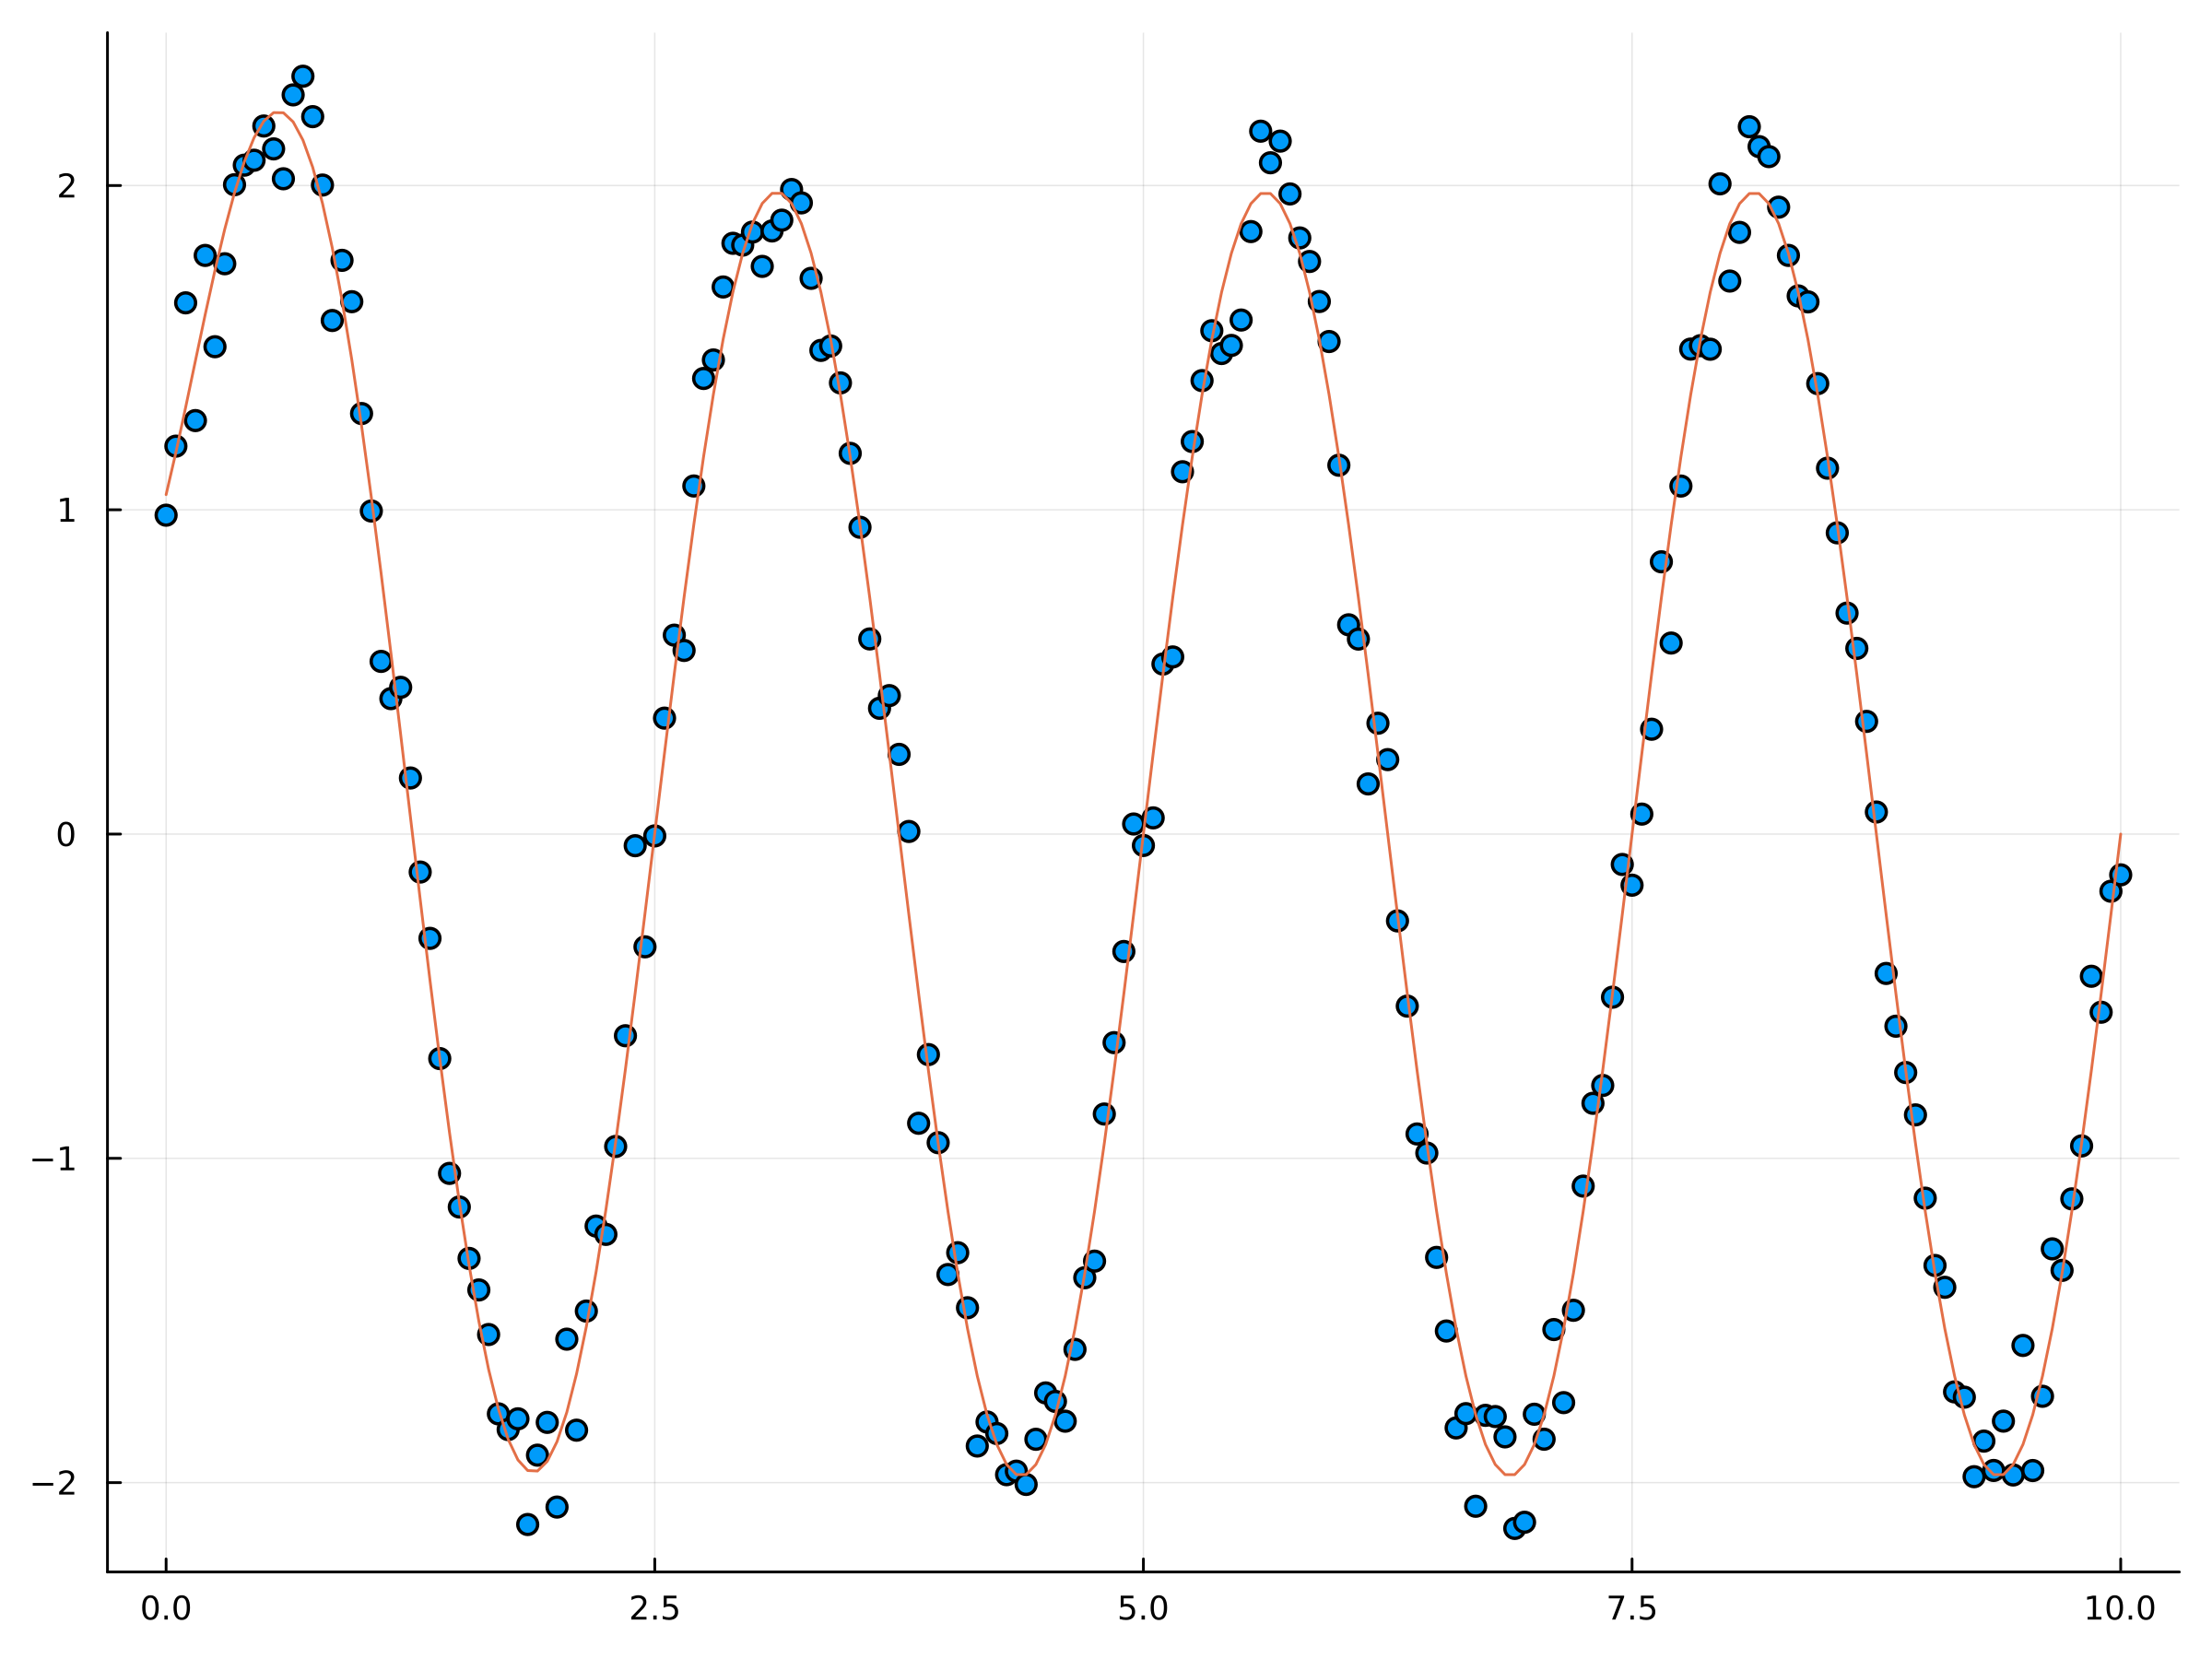

In [22]:
p = myfit.param
findyvals = p[1]*exp.(-xvals*p[2]) + p[3]*sin.(0.8*pi*xvals)
scatter(xvals,yvals,legend=false)
plot!(xvals,findyvals)

Just for fun... Let's try to fit a linear function

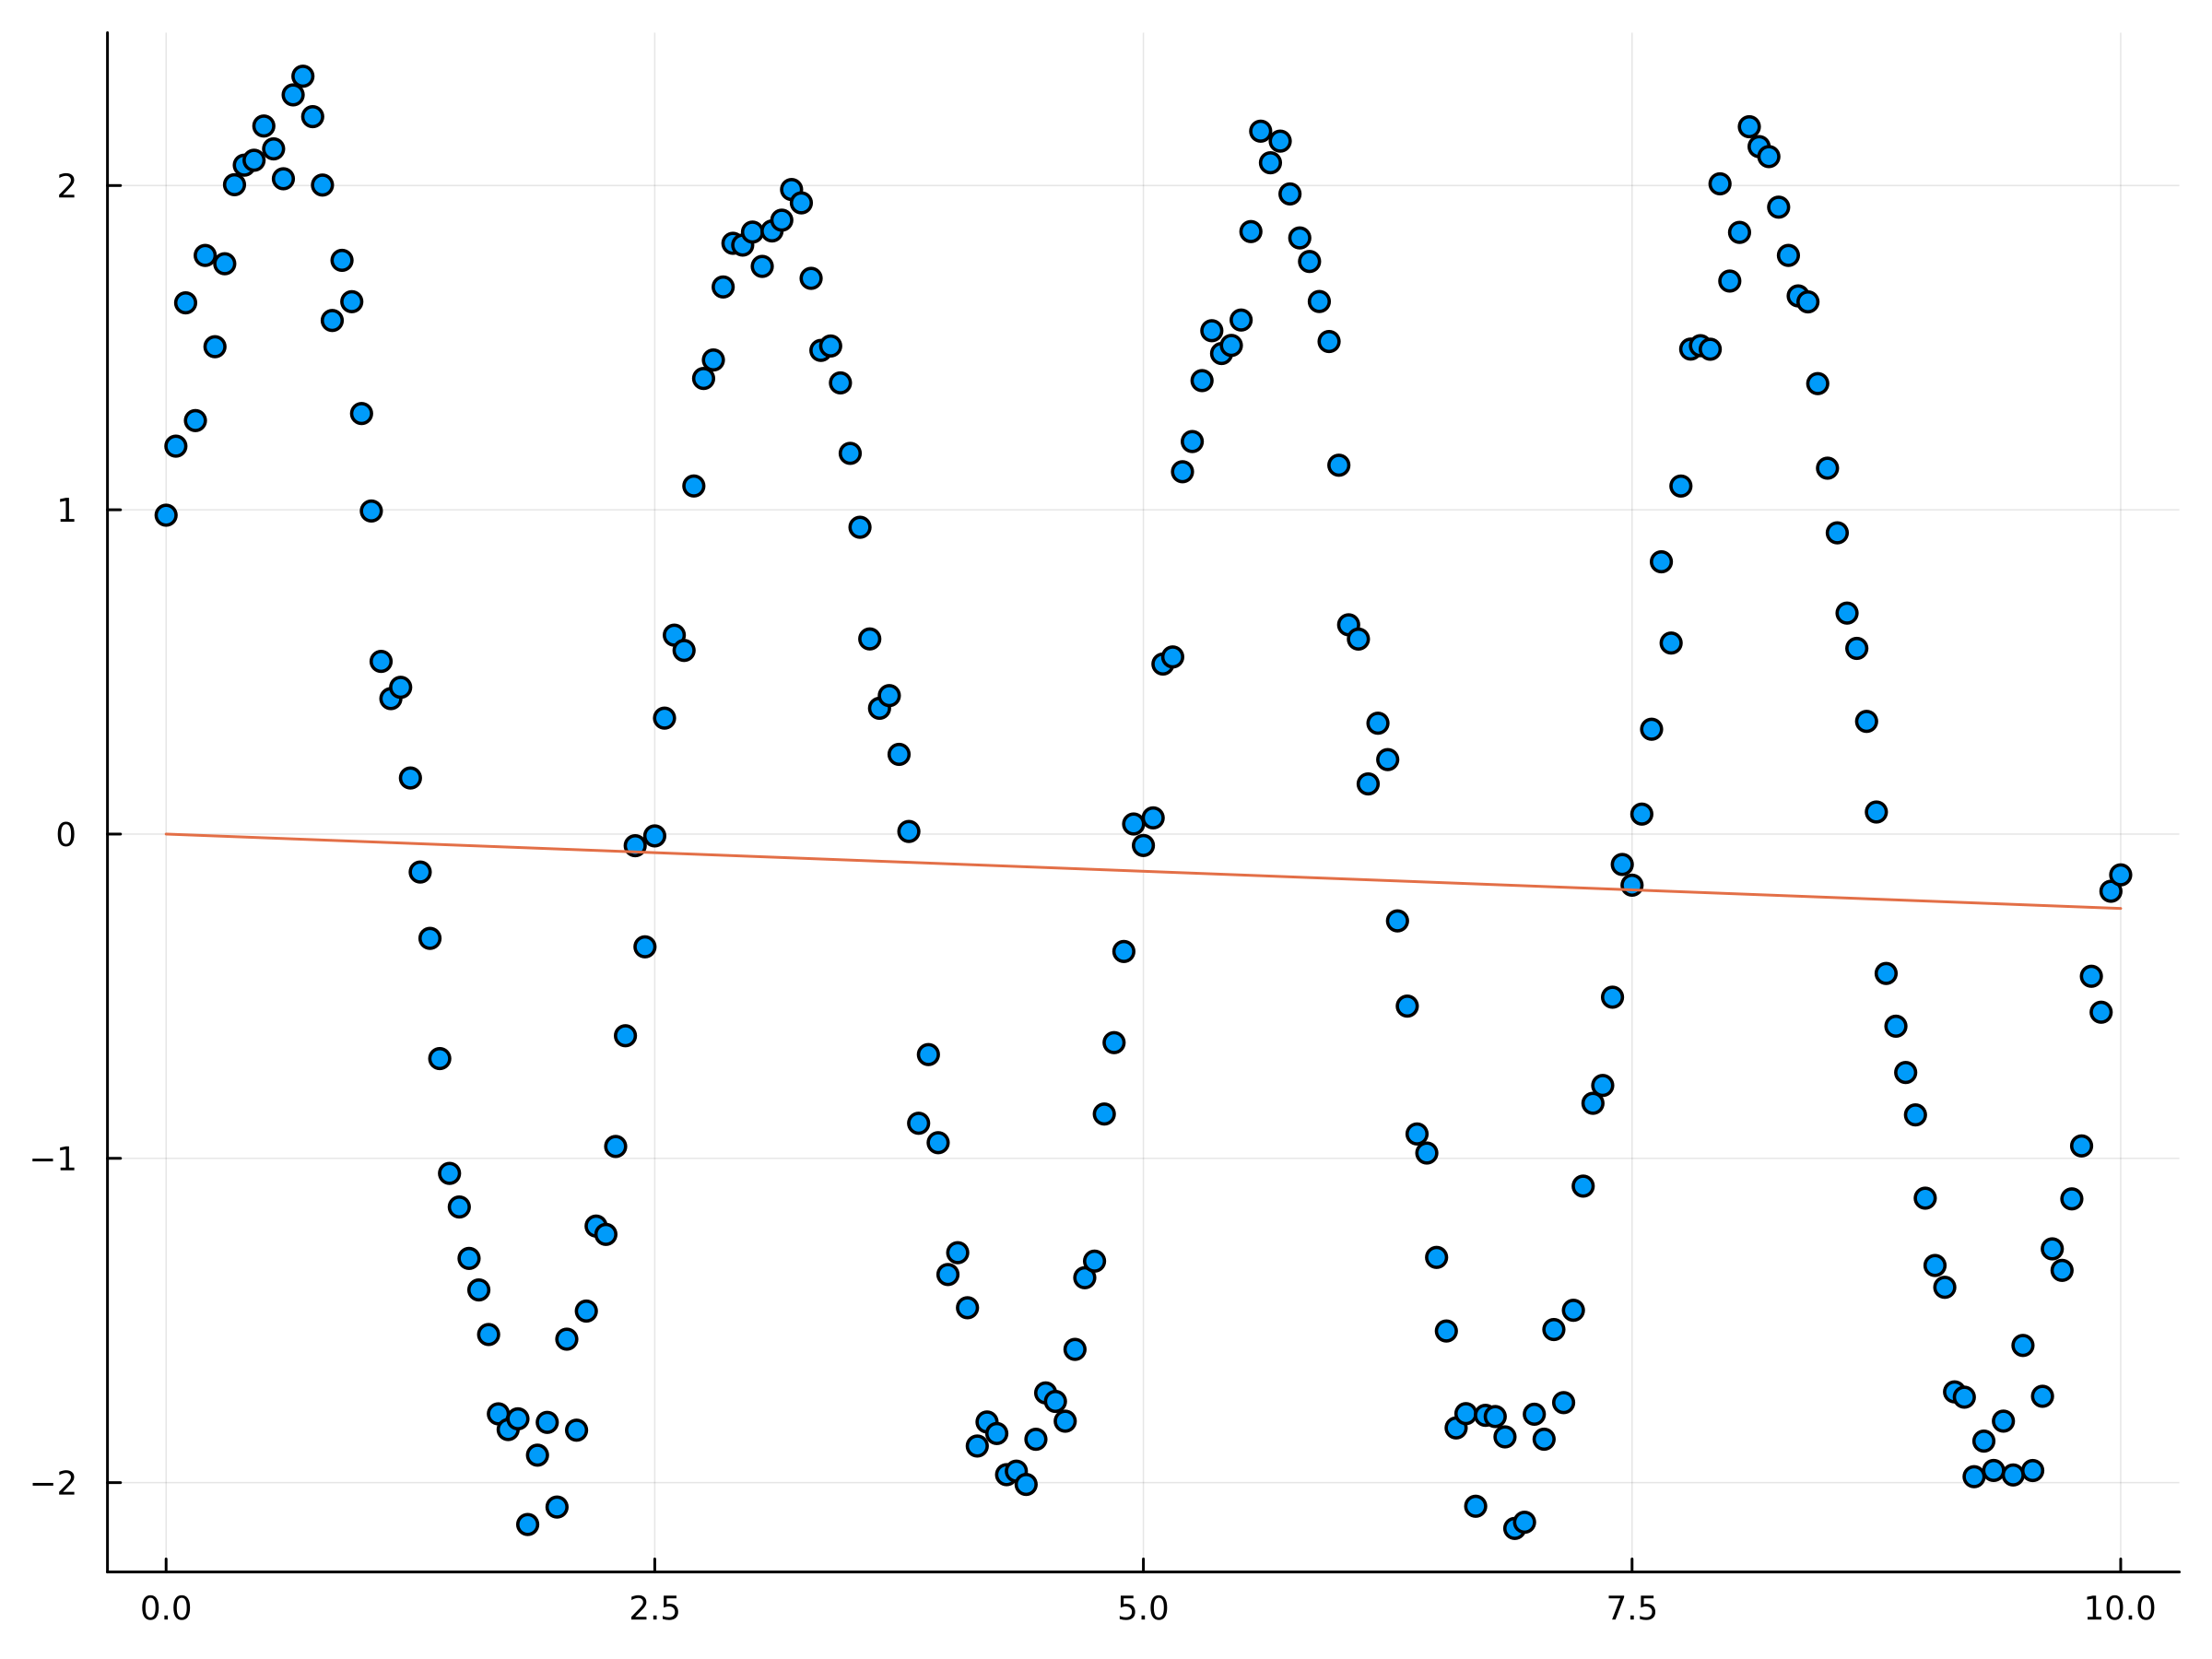

In [23]:
@. model(x, p) = p[1]*x
myfit = curve_fit(model, xvals, yvals, [0.5])
p = myfit.param
findyvals = p[1]*xvals
scatter(xvals,yvals,legend=false)
plot!(xvals,findyvals)

# Finally...
After finishing this notebook, you should be able to:
- run a linear regression model
- use the GLM package to pass functions and probability distributions to solve your special regression problem
- fit a nonlinear regression to your data using the LsqFit package